In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.table import Table, vstack,hstack
import numpy.ma as ma

In [2]:
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['savefig.dpi'] = 300

In [3]:
master_table_fn = '/Users/nityaravi/Documents/Research/RotationCurves/data/manga/output_files/DR17/CURRENT_MASTER_TABLE/Elliptical_StelVelDispDAPMeanSigma_Mvir_smoothness_lt_2_dipole_vflag_comoving.fits'
master_table = Table.read(master_table_fn, format='fits')

In [4]:
master_table[0:5]

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag,nsa_elpetro_absmag,nsa_elpetro_amivar,nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction,nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux,nsa_petro_flux_ivar,nsa_elpetro_flux,nsa_elpetro_flux_ivar,nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux,nsa_sersic_flux_ivar,smoothness_score,nsa_elpetro_th90,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,v_max,v_max_err,r_turn,r_turn_err,chi2,alpha,alpha_err,Rmax,M,M_err,fit_flag,Sigma_disk,Sigma_disk_err,R_disk,R_disk_err,rho_bulge,rho_bulge_err,R_bulge,R_bulge_err,M90_disk,M90_disk_err,M_disk,M_disk_err,chi2_disk,logHI,logHIlim,WF50,WF50_err,DL_ttype,vis_tidal,b,b_err,M_R90,M_R90_err,fit_function,A_g,A_r,logH2,R90_kpc,v_3p5,v_3p5_err,NSA_plate,NSA_fiberID,NSA_MJD,logH2_CG,logH2_CG_err,logH2_M,Z,Z_err,M_Z,M_Z_err,grad_Z,grad_Z_err,Z_0,Z_0_err,SFR,sSFR,SFR_err,sSFR_err,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,Flux_OII_3728_Err,Flux_OIII_4958,Flux_OIII_4958_Err,Flux_OIII_5006,Flux_OIII_5006_Err,Flux_NII_6547,Flux_NII_6547_Err,Flux_NII_6583,Flux_NII_6583_Err,Flux_Ha_6562,Flux_Ha_6562_Err,Flux_Hb_4861,Flux_Hb_4861_Err,CMD_class,rabsmag_NSA,param_H2,param_H2_err,Z_map,Z_err_map,M_Z_map,M_Z_err_map,logHI_R90,Mvir,Mvir_err,star_sigma,star_sigma_err,dipole_moment,Rgal,vflag_VF
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64,float64,float64[7],float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64[7],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,int64
10001,12701,10001-12701,1-48157,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.371090612,57.5984251446,159.27921887,38.8381829181,133.37109,57.598425,0.0545561,9,8100.81,0,20.0835,41.292,ma079,22,3,9114,134.41357,57.604214,1.10715,1.15321,1.21404,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.69906,2.64546,2.59645,2.54039,2080,0,0,1,plateTargets-1.par,6013,J085329.03+573554.9,127,127,0,

In [5]:
ellipticals = master_table[master_table['Mvir'] > 0]

## Get sample of spirals with cuts

1. vmax > 0
2. m90_disk > 0
3. 10 > v90 > 1000
4. alpha < 99
5. vmax_err/vmax < 2
6. stellar mass > 9

In [6]:
spirals = master_table[master_table['v_max'] > 0]
spirals = spirals[spirals['M90_disk'] > 0]
spirals = spirals[spirals['alpha'] <= 99]
spirals = spirals[spirals['v_max_err']/spirals['v_max'] <= 2]

In [7]:
v90 = spirals['v_max'] * spirals['R90_kpc'] / (spirals['r_turn']**spirals['alpha'] + spirals['R90_kpc']**spirals['alpha'])**(1/spirals['alpha'])

In [8]:
all_mass_spirals = spirals[np.logical_and(v90 > 10, v90 < 1000)]
spirals = all_mass_spirals[all_mass_spirals['M90_disk']>9]

## get magnitudes

In [9]:
e_mag = np.zeros(len(ellipticals))
s_mag = np.zeros(len(spirals))

for i in range(len(e_mag)):
    e_mag[i] = ellipticals['nsa_elpetro_absmag'][i][4]
    

for i in range(len(s_mag)):
    s_mag[i] = spirals['nsa_elpetro_absmag'][i][4]

## Median calculation functions

In [13]:
def med_err(vals, logscale=True):
    '''
    Takes a a list of values in bins, calculates the log median and uncertainty (RMS/sqrt(N)) and returns log median and log err bars

    vals : array
        2D array of dimension (N,M) corresponding to N bins in histogram
    
    '''

    
    err = np.zeros((2,len(vals)))
    med = np.zeros(len(vals))

    for i in range(len(vals)):
        if logscale:      
            med_val = np.median(10**vals[i]) # linear
            err_val = np.sqrt(np.mean((10**vals[i])**2)/len(vals[i]))
        else:
            med_val = np.median(vals[i]) # linear
            err_val = np.sqrt(np.mean(vals[i]**2)/len(vals[i]))

        print(med_val-err_val)
        err[0][i] = np.log10(med_val)-np.log10(med_val - err_val)
        err[1][i] = np.log10(med_val + err_val) - np.log10(med_val)
        med[i] = np.log10(med_val)

    return med, err
    

In [10]:
def med_percentile(vals, logscale=True, return_logscale=True):
    '''
    take array of vals in bins and calculate median, 16th, 84th percentiles in logscale

    PARAMETERS
    ==========
    val : array
        2d array (N,M) - N is number of bins

    logscale : boolean
        True if vals is in log units

    return_logscale : boolean
        True if percentiles are in log units

    RETURNS
    =======

    p : array
        array of medians, lower and upper bound of error bar (16th/84th percentile)
    
    '''

    p = np.ones((len(vals),3))*np.nan
    
    for i in range(len(vals)):
        if len(vals[i]) == 0:
            continue
        
        if len(vals[i]) >= 3:
            if logscale:
                a, b, c = np.percentile(10**vals[i],[50,16,84])
            else:
                a, b, c = np.percentile(vals[i],[50,16,84])
        else:
            if logscale:
                a = np.median(10**vals[i])
                b = a
                c = a
            else:
                a = np.median(vals[i])
                b = a
                c = a

        low = (a - b)
        high = (c - a)
        
        if return_logscale:
            p[i][0] = np.log10(a)
            p[i][1] = np.log10(a) - np.log10(b)
            p[i][2] = np.log10(c) - np.log10(a)
        
        else:
            p[i][0] = a
            p[i][1] = a - b
            p[i][2] = c - a
    
    return p

    

In [15]:
def med_percentile_scaled(vals, logscale=True, return_logscale=True):
    '''
    take array of vals in bins and calculate median, 16th, 84th percentiles in logscale
    if bin has < 10 data points, return nans

    PARAMETERS
    ==========
    val : array
        2d array (N,M) - N is number of bins

    logscale : boolean
        True if vals is in log units

    return_logscale : boolean
        True if percentiles are in log units

    RETURNS
    =======

    p : array
        median, lower error bar length, upper error bar length, in lin or log units
    '''

    p = np.ones((len(vals),3))*np.nan
    
    for i in range(len(vals)):
        if len(vals[i]) < 10:
            continue
        
        else:
            if logscale:
                a, b, c = np.percentile(10**vals[i],[50,16,84])
            else:
                a, b, c = np.percentile(vals[i],[50,16,84])
        # else:
        #     if logscale:
        #         a = np.median(10**vals[i])
        #         b = a
        #         c = a
        #     else:
        #         a = np.median(vals[i])
        #         b = a
        #         c = a

        low = (a - b) / np.sqrt(len(vals[i])) #lower error bar length (linear)
        high = (c - a) / np.sqrt(len(vals[i])) # upper error bar length (linear)
        
        if return_logscale:
            p[i][0] = np.log10(a)
            p[i][1] = np.log10(a) - np.log10(a-low)
            p[i][2] = np.log10(high+a) - np.log10(a)
        
        else:
            p[i][0] = a
            p[i][1] = low
            p[i][2] = high
    
    return p


# make plots

In [12]:
plot_dir = '/Users/nityaravi/Documents/Research/RotationCurves/data/manga/Ellipticals_Images/results_plots/'

In [17]:
Mvir = ellipticals['Mvir']
Mstar = np.log10(ellipticals['nsa_elpetro_mass'])
bins=np.histogram(np.hstack((Mvir,Mstar)), bins=10)[1]

## Mass and velocity dispersion histograms

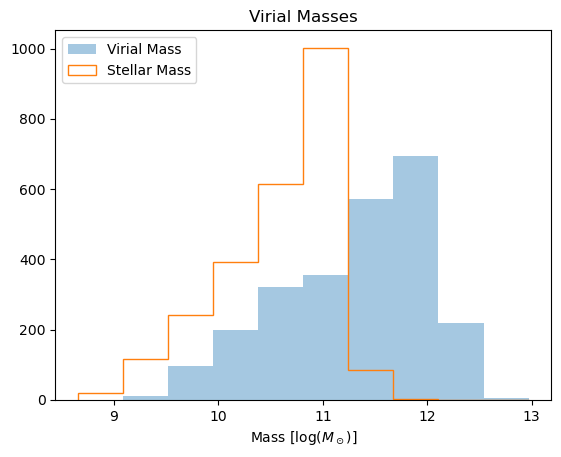

In [28]:
plt.hist(Mvir, label='Virial Mass', histtype='stepfilled', alpha=0.4, bins=bins)
plt.hist(Mstar, label='Stellar Mass', histtype='step', bins=bins)
plt.xlabel(r'Mass [$\log(M_\odot)$]')
plt.legend(loc='upper left')
plt.title('Virial Masses')
#plt.savefig(plot_dir + 'mass_distributions.png')
plt.show()

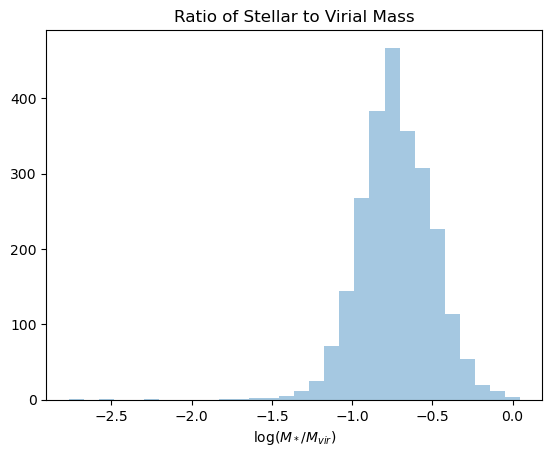

In [29]:
plt.hist(Mstar - Mvir, histtype='stepfilled', alpha=0.4, bins=30)
plt.xlabel('log($M_*/M_{vir}$)')
plt.title('Ratio of Stellar to Virial Mass')
#plt.savefig(plot_dir + 'mass_ratios.png')
plt.show()

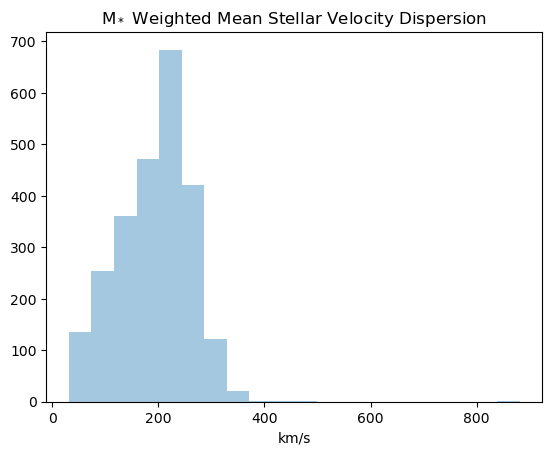

In [30]:
plt.hist(ellipticals['star_sigma'], histtype='stepfilled', alpha=0.4, bins=20)
plt.xlabel('km/s')
plt.title(r'M$_*$ Weighted Mean Stellar Velocity Dispersion')
#plt.savefig(plot_dir + 'median_sigma.png')
plt.show()

## ellipticals only plots

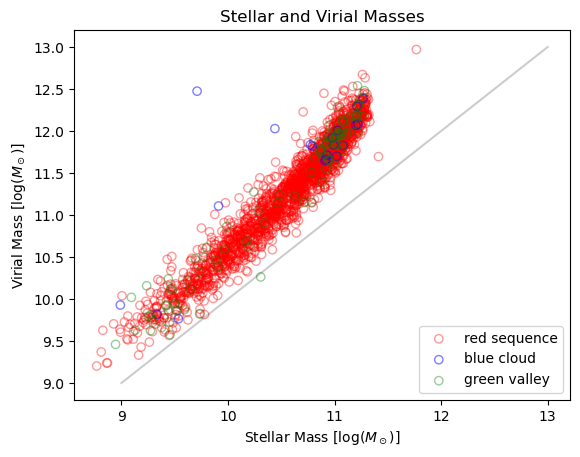

In [31]:
plt.scatter(Mstar[ellipticals['CMD_class'] == 3], Mvir[ellipticals['CMD_class'] == 3], 
            alpha=0.4, color = 'r', label='red sequence', facecolor='none')
plt.scatter(Mstar[ellipticals['CMD_class'] == 1], Mvir[ellipticals['CMD_class'] == 1], 
            color = 'b', alpha=0.5, label='blue cloud', facecolor='none')
plt.scatter(Mstar[ellipticals['CMD_class'] == 2], Mvir[ellipticals['CMD_class'] == 2], 
            alpha=0.4, color = 'g', label='green valley', facecolor='none')
plt.legend()
plt.ylabel(r'Virial Mass [$\log (M_\odot)$]')
plt.xlabel(r'Stellar Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.title('Stellar and Virial Masses')
#plt.savefig(plot_dir + 'mass_scatter.png')
plt.show()

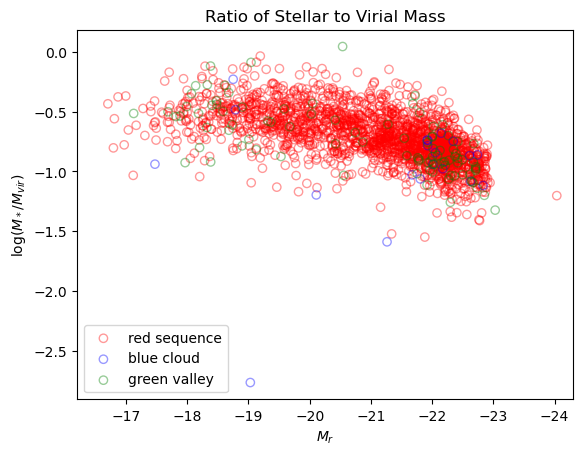

In [32]:
plt.scatter(e_mag[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3] - Mvir[ellipticals['CMD_class'] == 3], 
            alpha=0.4, color='r', label='red sequence', facecolor='none')
plt.scatter(e_mag[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1] - Mvir[ellipticals['CMD_class'] == 1], 
            alpha=0.4, color='b', label='blue cloud', facecolor='none')
plt.scatter(e_mag[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2] - Mvir[ellipticals['CMD_class'] == 2], 
            alpha=0.4, color='g', label='green valley', facecolor='none')

plt.legend()
plt.xlim(-16.2,-24.3)
plt.xlabel('$M_r$')
plt.title('Ratio of Stellar to Virial Mass')
plt.ylabel(r'$\log(M_*/M_{vir})$')
plt.savefig(plot_dir + 'mag_mratio.png')
plt.show()

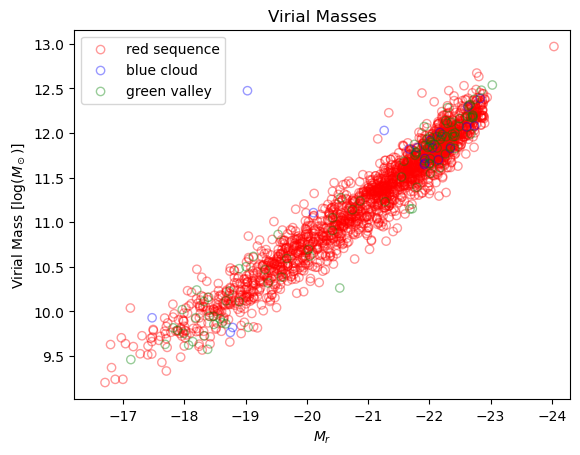

In [33]:
plt.scatter(e_mag[ellipticals['CMD_class'] == 3], Mvir[ellipticals['CMD_class'] == 3], 
            facecolor='none', color='r', alpha=0.4, label='red sequence')
plt.scatter(e_mag[ellipticals['CMD_class'] == 1], Mvir[ellipticals['CMD_class'] == 1], 
            facecolor='none', color='b', alpha=0.4, label='blue cloud')
plt.scatter(e_mag[ellipticals['CMD_class'] == 2], Mvir[ellipticals['CMD_class'] == 2], 
            facecolor='none', color='g', alpha=0.4, label='green valley')

plt.legend()
plt.xlabel('$M_r$')
plt.ylabel(r'Virial Mass [$\log(M_\odot)$]')
plt.title('Virial Masses')
plt.xlim(-16.2,-24.3)
#plt.savefig(plot_dir + 'mag_mvir_smoothness_lt_2.png')
plt.show()

## dipole moment plots

In [35]:
dipoles = master_table[master_table['dipole_moment'] > 0]

Text(0.5, 0, 'magnitude of dipole moment')

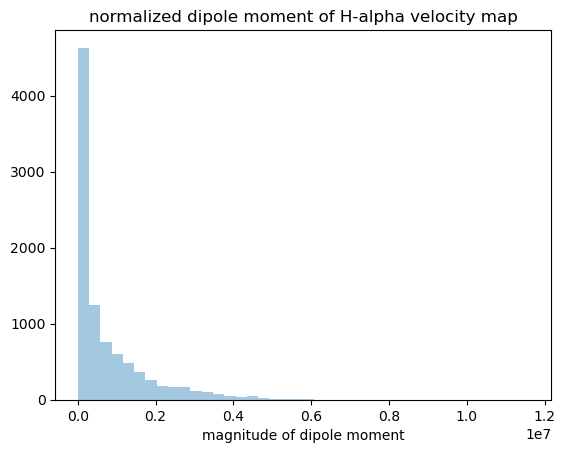

In [36]:
hist, bins, _ = plt.hist(dipoles['dipole_moment'], bins=40, alpha=0.4)

logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.title('normalized dipole moment of H-alpha velocity map')
plt.xlabel('magnitude of dipole moment')
#plt.savefig(plot_dir + 'norm_dipole_moment.png')

Text(0.5, 0, 'magnitude of dipole moment')

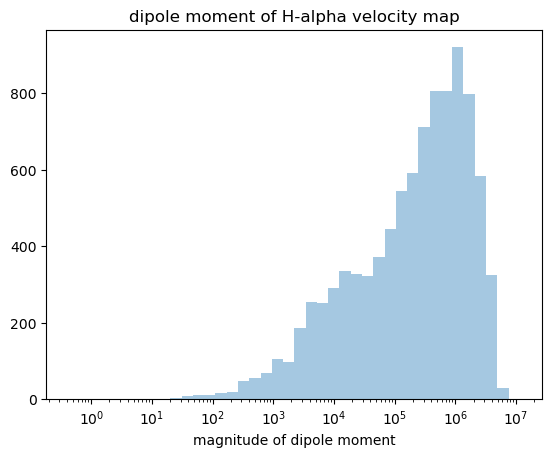

In [37]:
plt.hist(dipoles['dipole_moment'], bins=logbins, alpha=0.4)
plt.xscale('log')
plt.title('dipole moment of H-alpha velocity map')
plt.xlabel('magnitude of dipole moment')
#plt.savefig(plot_dir + 'norm_dipole_moment_log.png')

Text(0.5, 0, 'magnitude of dipole moment')

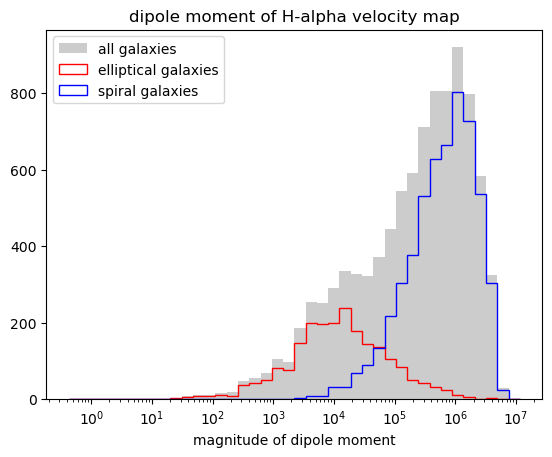

In [38]:
plt.hist(dipoles['dipole_moment'], bins=logbins, alpha=0.2, color='k', label='all galaxies')
plt.hist(dipoles[dipoles['Mvir'] > 0]['dipole_moment'], bins=logbins, histtype='step', color='r', label='elliptical galaxies')
plt.hist(spirals['dipole_moment'], bins=logbins, histtype='step', color='b', label='spiral galaxies')
plt.xscale('log')
plt.legend()
plt.title('dipole moment of H-alpha velocity map')
plt.xlabel('magnitude of dipole moment')
#plt.savefig(plot_dir + 'norm_dipole_moment_log_morph.png')

## full sample plots

### full sample stellar mass vs. total mass

In [20]:
tot_mass_bins = np.linspace(np.min(spirals['M_R90']), np.max(Mvir), 15)
tot_mass_points = (tot_mass_bins[1:] + tot_mass_bins[:-1])/2

s_mstar = []
e_mstar = []

for i in range(len(tot_mass_points)):
    mass_lim = tot_mass_bins[i+1]
    if i == 0:
        e_mstar.append(ellipticals['nsa_elpetro_mass'][Mvir <= mass_lim])
        s_mstar.append(spirals['M90_disk'][spirals['M_R90'] <= mass_lim])

    else:
        lower_lim = tot_mass_bins[i]
        e_mstar.append(ellipticals['nsa_elpetro_mass'][np.logical_and(Mvir <= mass_lim, Mvir > lower_lim)])
        s_mstar.append(spirals['M90_disk'][np.logical_and(spirals['M_R90'] <= mass_lim, spirals['M_R90'] > lower_lim)])

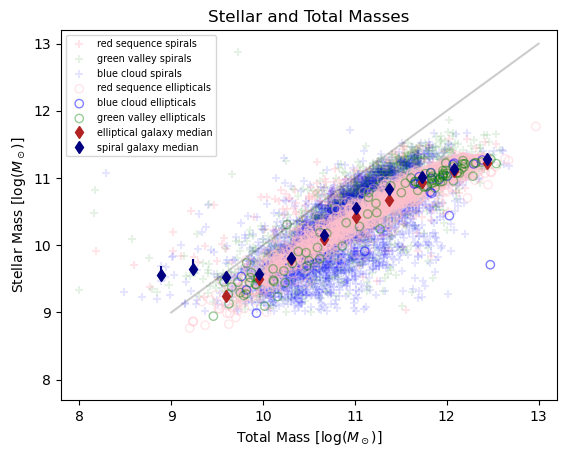

In [22]:
plt.scatter(spirals[spirals['CMD_class']==3]['M_R90'],spirals[spirals['CMD_class']==3]['M90_disk'],
            alpha=0.4, color='pink', marker='+', label='red sequence spirals')
plt.scatter(spirals[spirals['CMD_class']==2]['M_R90'],spirals[spirals['CMD_class']==2]['M90_disk'],
            alpha=0.1, color='g', marker='+', label='green valley spirals')
plt.scatter(spirals[spirals['CMD_class']==1]['M_R90'],spirals[spirals['CMD_class']==1]['M90_disk'],
            alpha=0.1, color='b', marker='+', label='blue cloud spirals')


plt.scatter(Mvir[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3],
            alpha=0.4, color = 'pink', label='red sequence ellipticals', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1],
            color = 'b', alpha=0.5, label='blue cloud ellipticals', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2],
            alpha=0.4, color = 'g', label='green valley ellipticals', facecolor='none')


ep = med_percentile_scaled(e_mstar, logscale=False, return_logscale=True)
sp = med_percentile_scaled(s_mstar, logscale=True, return_logscale=True)

plt.errorbar(tot_mass_points, ep[:,0], color='firebrick', yerr=[ep[:,1] ,ep[:,2]], 
             marker='d', label='elliptical galaxy median',linestyle='none')
plt.errorbar(tot_mass_points, sp[:,0], color='navy', yerr=[sp[:,1] ,sp[:,2]], 
             marker='d', label='spiral galaxy median',linestyle='none')
plt.legend(fontsize='x-small')
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Stellar Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.ylim(7.7,13.2)
plt.xlim(7.8,13.2)
plt.title('Stellar and Total Masses')
plt.savefig(plot_dir + 'mass_scatter_morph.png')
plt.show()

### full sample SHMR

In [23]:
s_SHMR = []
e_SHMR = []

for i in range(len(tot_mass_points)):
    mass_lim = tot_mass_bins[i+1]
    if i == 0:
        e_SHMR.append(Mstar[Mvir <= mass_lim] - Mvir[Mvir <= mass_lim])
        s_SHMR.append(spirals['M90_disk'][spirals['M_R90'] <= mass_lim] - spirals['M_R90'][spirals['M_R90'] <= mass_lim])

    else:
        lower_lim = tot_mass_bins[i]
        e_SHMR.append(Mstar[np.logical_and(Mvir <= mass_lim, Mvir > lower_lim)] - Mvir[np.logical_and(Mvir <= mass_lim, Mvir > lower_lim)])
        s_SHMR.append(spirals['M90_disk'][np.logical_and(spirals['M_R90'] <= mass_lim, spirals['M_R90'] > lower_lim)] - spirals['M_R90'][np.logical_and(spirals['M_R90'] <= mass_lim, spirals['M_R90'] > lower_lim)])

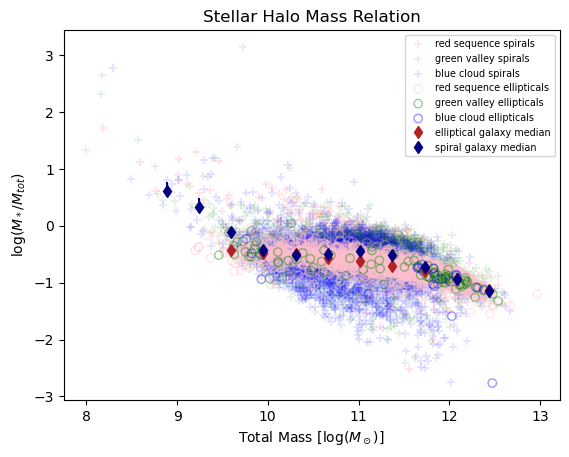

In [25]:
plt.scatter(spirals[spirals['CMD_class']==3]['M_R90'], 
            spirals[spirals['CMD_class']==3]['M90_disk']-spirals[spirals['CMD_class']==3]['M_R90'],
            alpha=0.4, color='pink', marker='+', label='red sequence spirals')
plt.scatter(spirals[spirals['CMD_class']==2]['M_R90'], 
            spirals[spirals['CMD_class']==2]['M90_disk']-spirals[spirals['CMD_class']==2]['M_R90'],
            alpha=0.1, color='g', marker='+', label='green valley spirals')
plt.scatter(spirals[spirals['CMD_class']==1]['M_R90'], 
            spirals[spirals['CMD_class']==1]['M90_disk']-spirals[spirals['CMD_class']==1]['M_R90'],
            alpha=0.1, color='b', marker='+', label='blue cloud spirals')


plt.scatter(Mvir[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3]-Mvir[ellipticals['CMD_class'] == 3],
            alpha=0.4, color = 'pink', label='red sequence ellipticals', facecolor='none')
            
plt.scatter(Mvir[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2]-Mvir[ellipticals['CMD_class'] == 2],
            alpha=0.4, color = 'g', label='green valley ellipticals', facecolor='none')
            
plt.scatter(Mvir[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1]-Mvir[ellipticals['CMD_class'] == 1],
            alpha=0.4, color = 'b', label='blue cloud ellipticals', facecolor='none')

ep = med_percentile_scaled(e_SHMR, True, True)
sp = med_percentile_scaled(s_SHMR, True, True)

plt.errorbar(tot_mass_points, ep[:,0], color='firebrick', yerr=[ep[:,1] ,ep[:,2]], 
             marker='d', label='elliptical galaxy median',linestyle='none')
plt.errorbar(tot_mass_points, sp[:,0], color='navy', yerr=[sp[:,1] ,sp[:,2]], 
             marker='d', label='spiral galaxy median',linestyle='none')
            
plt.legend(fontsize='x-small')
plt.ylabel(r'$\log(M_*/M_{tot})$')
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
#plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.title('Stellar Halo Mass Relation')
plt.savefig(plot_dir + 'SHMR_all_morph.png')
plt.show()

### total mass vs Mr

In [26]:
magnitude_bins = np.linspace(np.min(e_mag),np.max(s_mag),15)
points = (magnitude_bins[1:] + magnitude_bins[:-1])/2

e_vals = []
s_vals = []
for i in range(len(points)):
    mag_lim = magnitude_bins[i+1]
    if i == 0:
        e_vals.append(Mvir[e_mag <= mag_lim])
        s_vals.append(spirals['M_R90'][s_mag <= mag_lim])

    else:
        lower_lim = magnitude_bins[i]
        e_vals.append(Mvir[np.logical_and(e_mag <= mag_lim, e_mag > lower_lim)])
        s_vals.append(spirals['M_R90'][np.logical_and(s_mag <= mag_lim, s_mag > lower_lim)])



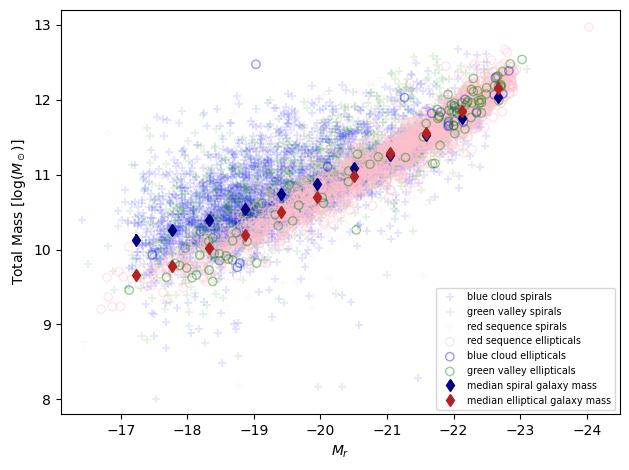

In [28]:
plt.scatter(s_mag[spirals['CMD_class'] == 1], spirals['M_R90'][spirals['CMD_class'] == 1], 
            color='blue', alpha=0.1, marker='+', label='blue cloud spirals')
plt.scatter(s_mag[spirals['CMD_class'] == 2], spirals['M_R90'][spirals['CMD_class'] == 2], 
            color='g', alpha=0.1,marker='+', label='green valley spirals')
plt.scatter(s_mag[spirals['CMD_class'] == 3], spirals['M_R90'][spirals['CMD_class'] == 3], 
            color='pink', alpha=0.1,marker='+', label='red sequence spirals')
plt.scatter(e_mag[ellipticals['CMD_class'] == 3], Mvir[ellipticals['CMD_class'] == 3], 
            color='pink', alpha=0.4, label='red sequence ellipticals', facecolor='none')
plt.scatter(e_mag[ellipticals['CMD_class'] == 1], Mvir[ellipticals['CMD_class'] == 1], 
            color='b', alpha=0.4, label='blue cloud ellipticals', facecolor='none')
plt.scatter(e_mag[ellipticals['CMD_class'] == 2], Mvir[ellipticals['CMD_class'] == 2], 
            color='g', alpha=0.4, label='green valley ellipticals', facecolor='none')

ep = med_percentile_scaled(e_vals)
sp = med_percentile_scaled(s_vals)

plt.errorbar(points, sp[:,0], color='navy', yerr=[sp[:,1] ,sp[:,2]], 
             marker='d', label='median spiral galaxy mass',linestyle='none')

plt.errorbar(points, ep[:,0], color='firebrick', yerr=[ep[:,1] ,ep[:,2]], 
             marker='d', label='median elliptical galaxy mass', linestyle='none')

plt.legend(fontsize='x-small')
plt.xlabel('$M_r$')
plt.ylabel(r'Total Mass [$\log(M_\odot)$]')
plt.tight_layout()
#plt.title('Spiral and Elliptical Galaxy Masses')
#plt.xlim(-16.9,-23.5)
#plt.xlim(-16.8,-22.9)
plt.xlim(-16.1, -24.5)
plt.ylim(7.8,13.2)
plt.savefig(plot_dir + 'med_mag_totmass_allmorph_err.png')
plt.show()

### def void and wall samples

In [31]:
s_void_mask = spirals['vflag_VF'] == 1
e_void_mask = ellipticals['vflag_VF'] == 1
s_wall_mask = spirals['vflag_VF'] == 0
e_wall_mask = ellipticals['vflag_VF'] == 0

s_void = spirals[s_void_mask]
s_mag_void = s_mag[s_void_mask]

e_void = ellipticals[e_void_mask]
e_mag_void = e_mag[e_void_mask]

s_wall = spirals[s_wall_mask]
s_mag_wall = s_mag[s_wall_mask]

e_wall = ellipticals[e_wall_mask]
e_mag_wall = e_mag[e_wall_mask]


### void vs. wall total mass(R90 for spirals) vs. Mr 

In [32]:
s_void_vals = []
e_void_vals = []
s_wall_vals = []
e_wall_vals = []


for i in range(len(points)):
    mag_lim = magnitude_bins[i+1]
    if i == 0:
        s_void_vals.append(s_void['M_R90'][s_mag_void <= mag_lim])
        e_void_vals.append(e_void['Mvir'][e_mag_void <= mag_lim])
        s_wall_vals.append(s_wall['M_R90'][s_mag_wall <= mag_lim])
        e_wall_vals.append(e_wall['Mvir'][e_mag_wall <= mag_lim])
    else:
        lower_lim = magnitude_bins[i]

        s_void_vals.append(s_void['M_R90'][np.logical_and(s_mag_void <= mag_lim, s_mag_void > lower_lim)])
        e_void_vals.append(e_void['Mvir'][np.logical_and(e_mag_void <= mag_lim, e_mag_void > lower_lim)])
        s_wall_vals.append(s_wall['M_R90'][np.logical_and(s_mag_wall <= mag_lim, s_mag_wall > lower_lim)])
        e_wall_vals.append(e_wall['Mvir'][np.logical_and(e_mag_wall <= mag_lim, e_mag_wall > lower_lim)])


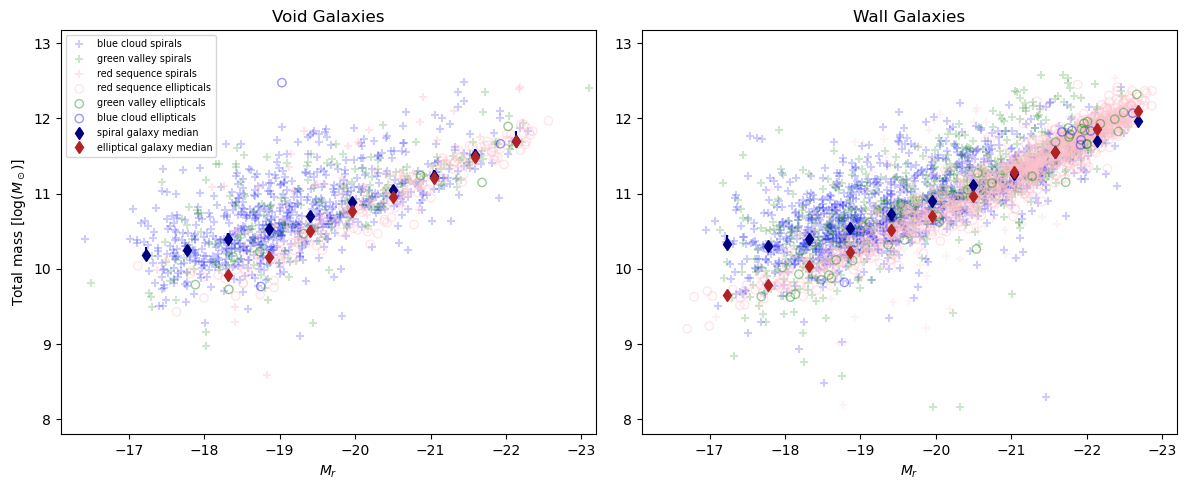

In [36]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

#labels

ax[0].set_title('Void Galaxies')
ax[1].set_title('Wall Galaxies')

ax[0].set_xlim(-16.1,-23.2)
ax[1].set_xlim(-16.1,-23.2)


ax[0].set_ylabel(r'Total mass [$\log(M_\odot)$]')
ax[0].set_xlabel('$M_r$')
ax[1].set_xlabel('$M_r$')
ax[0].set_ylim(np.min(spirals['M_R90'])-0.2,np.max(Mvir)+0.2)
ax[1].set_ylim(np.min(spirals['M_R90'])-0.2,np.max(Mvir)+0.2)


#void data
ax[0].scatter(s_mag_void[s_void['CMD_class'] == 1],s_void[s_void['CMD_class'] == 1]['M_R90'],
              color='b', alpha=0.2, marker='+', label='blue cloud spirals')
ax[0].scatter(s_mag_void[s_void['CMD_class'] == 2],s_void[s_void['CMD_class'] == 2]['M_R90'],
              color='g', alpha=0.2, marker='+', label='green valley spirals')
ax[0].scatter(s_mag_void[s_void['CMD_class'] == 3],s_void[s_void['CMD_class'] == 3]['M_R90'],
              color='pink', alpha=0.4, marker='+', label='red sequence spirals')

ax[0].scatter(e_mag_void[e_void['CMD_class'] == 3],e_void[e_void['CMD_class'] == 3]['Mvir'],
              color='pink', alpha=0.4, marker='o', label='red sequence ellipticals', facecolor='none')
ax[0].scatter(e_mag_void[e_void['CMD_class'] == 2],e_void[e_void['CMD_class'] == 2]['Mvir'],
              color='g', alpha=0.4, marker='o', label='green valley ellipticals', facecolor='none')
ax[0].scatter(e_mag_void[e_void['CMD_class'] == 1],e_void[e_void['CMD_class'] == 1]['Mvir'],
              color='b', alpha=0.4, marker='o', label='blue cloud ellipticals', facecolor='none')

#wall data
ax[1].scatter(s_mag_wall[s_wall['CMD_class'] == 1],s_wall[s_wall['CMD_class'] == 1]['M_R90'],
              color='b', alpha=0.2, marker='+')
ax[1].scatter(s_mag_wall[s_wall['CMD_class'] == 2],s_wall[s_wall['CMD_class'] == 2]['M_R90'],
              color='g', alpha=0.2, marker='+')
ax[1].scatter(s_mag_wall[s_wall['CMD_class'] == 3],s_wall[s_wall['CMD_class'] == 3]['M_R90'],
              color='pink', alpha=0.2, marker='+')

ax[1].scatter(e_mag_wall[e_wall['CMD_class'] == 3],e_wall[e_wall['CMD_class'] == 3]['Mvir'],
              color='pink', alpha=0.4, marker='o', label='red sequence', facecolor='none')
ax[1].scatter(e_mag_wall[e_wall['CMD_class'] == 2],e_wall[e_wall['CMD_class'] == 2]['Mvir'],
              color='g', alpha=0.4, marker='o', label='green valley', facecolor='none')
ax[1].scatter(e_mag_wall[e_wall['CMD_class'] == 1],e_wall[e_wall['CMD_class'] == 1]['Mvir'],
              color='b', alpha=0.4, marker='o', label='blue cloud', facecolor='none')


sp_void = med_percentile_scaled(s_void_vals)
sp_wall = med_percentile_scaled(s_wall_vals)
ep_void = med_percentile_scaled(e_void_vals)
ep_wall = med_percentile_scaled(e_wall_vals)

ax[0].errorbar(points, sp_void[:,0], color='navy', yerr=[sp_void[:,1] ,sp_void[:,2]], 
             marker='d', label='spiral galaxy median',linestyle='none')

ax[0].errorbar(points, ep_void[:,0], color='firebrick', yerr=[ep_void[:,1] ,ep_void[:,2]], 
             marker='d', label='elliptical galaxy median', linestyle='none')


ax[1].errorbar(points, sp_wall[:,0], color='navy', yerr=[sp_wall[:,1] ,sp_wall[:,2]], 
             marker='d',linestyle='none')

ax[1].errorbar(points, ep_wall[:,0], color='firebrick', yerr=[ep_wall[:,1] ,ep_wall[:,2]], 
             marker='d', linestyle='none')

ax[0].legend(fontsize='x-small')

fig.tight_layout()
fig.savefig(plot_dir + 'void_wall_all_err.png', )


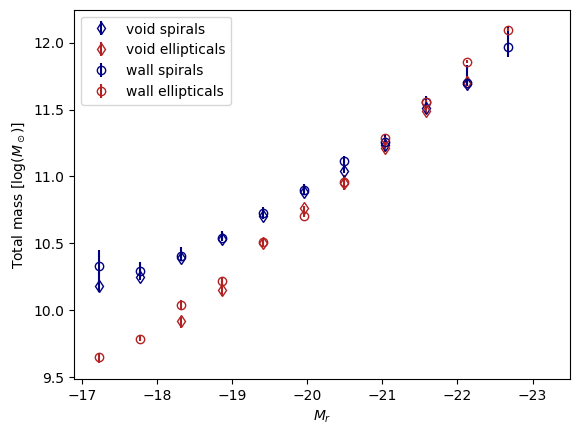

In [39]:
plt.errorbar(points, sp_void[:,0], color='navy', yerr=[sp_void[:,1] ,sp_void[:,2]], 
             marker='d', label='void spirals',linestyle='none', markerfacecolor='none')

plt.errorbar(points, ep_void[:,0], color='firebrick', yerr=[ep_void[:,1] ,ep_void[:,2]], 
             marker='d', label='void ellipticals', linestyle='none', markerfacecolor='none')


plt.errorbar(points, sp_wall[:,0], color='navy', yerr=[sp_wall[:,1] ,sp_wall[:,2]], 
             marker='o',label='wall spirals', linestyle='none', markerfacecolor='none')

plt.errorbar(points, ep_wall[:,0], color='firebrick', yerr=[ep_wall[:,1] ,ep_wall[:,2]], 
             marker='o',label='wall ellipticals', linestyle='none', markerfacecolor='none')


#plt.title('Median total mass')
plt.xlabel('$M_r$')
plt.ylabel(r'Total mass [$\log(M_\odot)$]')
#plt.yscale('log')
plt.legend()
plt.xlim((-16.9,-23.5))
plt.savefig(plot_dir + 'med_tot_mass_env_err.png')
#plt.savefig(plot_dir + 'med_tot_mass_env.png')
plt.show()

### void vs. wall stellar mass vs total mass (all within r90 for spirals)

In [40]:
s_void_mstar = []
e_void_mstar = []

s_wall_mstar = []
e_wall_mstar = []

for i in range(len(tot_mass_points)):
    mass_lim = tot_mass_bins[i+1]
    if i == 0:
        e_void_mstar.append(e_void['nsa_elpetro_mass'][e_void['Mvir'] <= mass_lim])
        s_void_mstar.append(s_void['M90_disk'][s_void['M_R90'] <= mass_lim])
        e_wall_mstar.append(e_wall['nsa_elpetro_mass'][e_wall['Mvir'] <= mass_lim])
        s_wall_mstar.append(s_wall['M90_disk'][s_wall['M_R90'] <= mass_lim])

    else:
        lower_lim = tot_mass_bins[i]
        e_void_mstar.append(e_void['nsa_elpetro_mass'][np.logical_and(e_void['Mvir'] <= mass_lim, e_void['Mvir'] > lower_lim)])
        s_void_mstar.append(s_void['M90_disk'][np.logical_and(s_void['M_R90'] <= mass_lim, s_void['M_R90'] > lower_lim)])
        e_wall_mstar.append(e_wall['nsa_elpetro_mass'][np.logical_and(e_wall['Mvir'] <= mass_lim, e_wall['Mvir'] > lower_lim)])
        s_wall_mstar.append(s_wall['M90_disk'][np.logical_and(s_wall['M_R90'] <= mass_lim, s_wall['M_R90'] > lower_lim)])

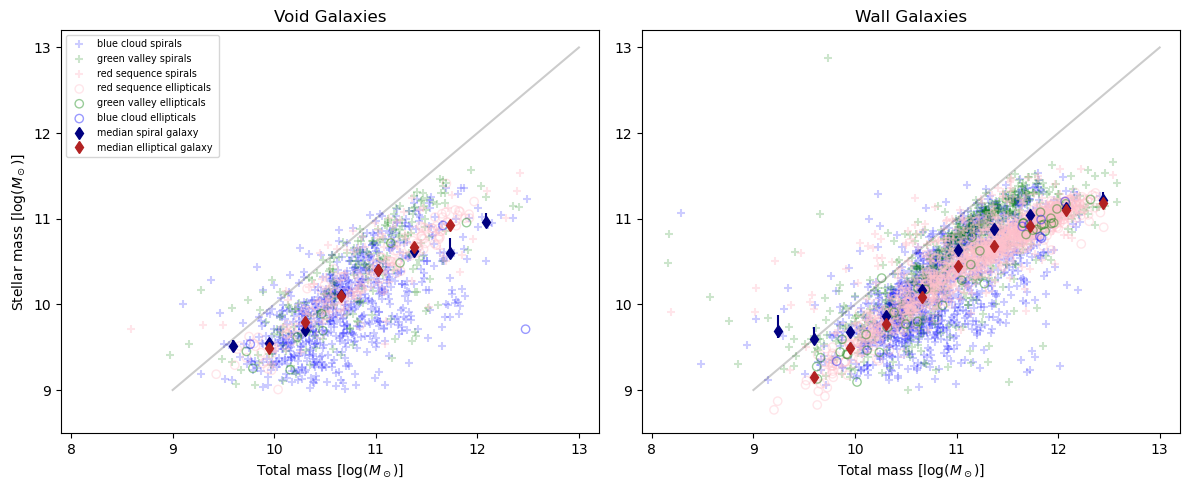

In [42]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

#labels

ax[0].set_title('Void Galaxies')
ax[1].set_title('Wall Galaxies')

ax[0].set_xlabel(r'Total mass [$\log(M_\odot)$]')
ax[1].set_xlabel(r'Total mass [$\log(M_\odot)$]')
ax[0].set_ylabel(r'Stellar mass [$\log(M_\odot)]$')

ax[0].set_ylim(8.5,13.2)
ax[1].set_ylim(8.5,13.2)
ax[0].set_xlim(7.9,13.2)
ax[1].set_xlim(7.9,13.2)

ax[0].plot([9,13],[9,13],color='k',alpha=0.2)
ax[1].plot([9,13],[9,13],color='k',alpha=0.2)

#void
ax[0].scatter(s_void[s_void['CMD_class'] == 1]['M_R90'],s_void[s_void['CMD_class'] == 1]['M90_disk'],
              color='b', alpha=0.2, marker='+',label='blue cloud spirals')
ax[0].scatter(s_void[s_void['CMD_class'] == 2]['M_R90'],s_void[s_void['CMD_class'] == 2]['M90_disk'],
              color='g', alpha=0.2, marker='+', label='green valley spirals')
ax[0].scatter(s_void[s_void['CMD_class'] == 3]['M_R90'],s_void[s_void['CMD_class'] == 3]['M90_disk'],
              color='pink', alpha=0.4, marker='+', label='red sequence spirals')

ax[0].scatter(e_void[e_void['CMD_class'] == 3]['Mvir'],np.log10(e_void[e_void['CMD_class'] == 3]['nsa_elpetro_mass']),
              color='pink', alpha=0.4, marker='o', label='red sequence ellipticals', facecolor='none')
ax[0].scatter(e_void[e_void['CMD_class'] == 2]['Mvir'],np.log10(e_void[e_void['CMD_class'] == 2]['nsa_elpetro_mass']),
              color='g', alpha=0.4, marker='o', label='green valley ellipticals', facecolor='none')
ax[0].scatter(e_void[e_void['CMD_class'] == 1]['Mvir'],np.log10(e_void[e_void['CMD_class'] == 1]['nsa_elpetro_mass']),
              color='b', alpha=0.4, marker='o', label='blue cloud ellipticals', facecolor='none')



#wall
ax[1].scatter(s_wall[s_wall['CMD_class'] == 1]['M_R90'],s_wall[s_wall['CMD_class'] == 1]['M90_disk'],
              color='b', alpha=0.2, marker='+')
ax[1].scatter(s_wall[s_wall['CMD_class'] == 2]['M_R90'],s_wall[s_wall['CMD_class'] == 2]['M90_disk'],
              color='g', alpha=0.2, marker='+')
ax[1].scatter(s_wall[s_wall['CMD_class'] == 3]['M_R90'],s_wall[s_wall['CMD_class'] == 3]['M90_disk'],
              color='pink', alpha=0.4, marker='+')

ax[1].scatter(e_wall[e_wall['CMD_class'] == 3]['Mvir'],np.log10(e_wall[e_wall['CMD_class'] == 3]['nsa_elpetro_mass']),
              color='pink', alpha=0.4, marker='o', label='red sequence', facecolor='none')
ax[1].scatter(e_wall[e_wall['CMD_class'] == 2]['Mvir'],np.log10(e_wall[e_wall['CMD_class'] == 2]['nsa_elpetro_mass']),
              color='g', alpha=0.4, marker='o', label='green valley', facecolor='none')
ax[1].scatter(e_wall[e_wall['CMD_class'] == 1]['Mvir'],np.log10(e_wall[e_wall['CMD_class'] == 1]['nsa_elpetro_mass']),
              color='b', alpha=0.4, marker='o', label='blue cloud', facecolor='none')

sp_void_mstar = med_percentile_scaled(s_void_mstar)
sp_wall_mstar = med_percentile_scaled(s_wall_mstar)
ep_void_mstar = med_percentile_scaled(e_void_mstar, False, True)
ep_wall_mstar = med_percentile_scaled(e_wall_mstar, False, True)

ax[0].errorbar(tot_mass_points, sp_void_mstar[:,0], color='navy', yerr=[sp_void_mstar[:,1] ,sp_void_mstar[:,2]], 
             marker='d', label='median spiral galaxy',linestyle='none', )

ax[0].errorbar(tot_mass_points, ep_void_mstar[:,0], color='firebrick', yerr=[ep_void_mstar[:,1] ,ep_void_mstar[:,2]], 
             marker='d', label='median elliptical galaxy ', linestyle='none', )


ax[1].errorbar(tot_mass_points, sp_wall_mstar[:,0], color='navy', yerr=[sp_wall_mstar[:,1] ,sp_wall_mstar[:,2]], 
             marker='d',linestyle='none')

ax[1].errorbar(tot_mass_points, ep_wall_mstar[:,0], color='firebrick', yerr=[ep_wall_mstar[:,1] ,ep_wall_mstar[:,2]], 
             marker='d', linestyle='none')


ax[0].legend(fontsize='x-small')

fig.tight_layout()
fig.savefig(plot_dir + 'env_stellar_total_mass.png')

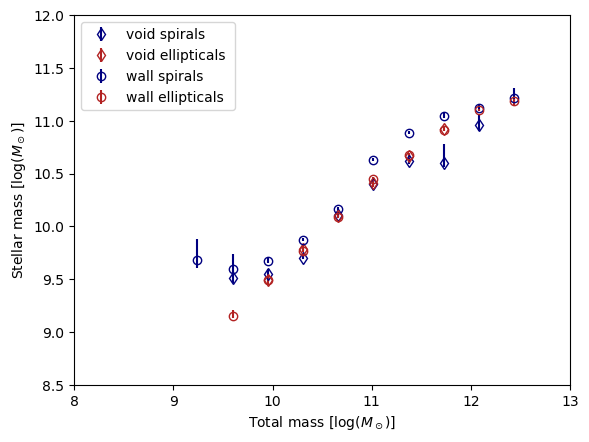

In [43]:
plt.errorbar(tot_mass_points, sp_void_mstar[:,0], color='navy', yerr=[sp_void_mstar[:,1] ,sp_void_mstar[:,2]], 
             marker='d', label='void spirals',linestyle='none', markerfacecolor='none' )

plt.errorbar(tot_mass_points, ep_void_mstar[:,0], color='firebrick', yerr=[ep_void_mstar[:,1] ,ep_void_mstar[:,2]], 
             marker='d', label='void ellipticals ', linestyle='none', markerfacecolor='none')


plt.errorbar(tot_mass_points, sp_wall_mstar[:,0], color='navy', yerr=[sp_wall_mstar[:,1] ,sp_wall_mstar[:,2]], 
             marker='o',linestyle='none', label='wall spirals', markerfacecolor='none')

plt.errorbar(tot_mass_points, ep_wall_mstar[:,0], color='firebrick', yerr=[ep_wall_mstar[:,1] ,ep_wall_mstar[:,2]], 
             marker='o', linestyle='none', label='wall ellipticals', markerfacecolor='none')


#plt.title('Median total mass')
plt.xlabel(r'Total mass [$\log(M_\odot)$]')
plt.ylabel(r'Stellar mass [$\log(M_\odot)$]')
#plt.yscale('log')
plt.legend()
plt.ylim(8.5,12)
plt.xlim(8,13)
plt.savefig(plot_dir + 'med_mstar_env.png')
plt.show()

### void vs wall total vs stellar mass binned by stellar mass

In [157]:
mstar_bins = np.linspace(np.min([np.min(spirals['M90_disk']) ,np.log10(np.min(ellipticals['nsa_elpetro_mass']))]),
                             np.max([np.max(spirals['M90_disk']), np.log10(np.max(ellipticals['nsa_elpetro_mass']))]),
                             20)
                             


mstar_points = (mstar_bins[1:] + mstar_bins[:-1])/2

s_void_mtot = []
e_void_mtot = []

s_wall_mtot = []
e_wall_mtot = []

for i in range(len(mstar_points)):
    mass_lim = mstar_bins[i+1]
    if i == 0:
        e_void_mtot.append(e_void['Mvir'][np.log10(e_void['nsa_elpetro_mass']) <= mass_lim])
        s_void_mtot.append(s_void['M_R90'][s_void['M90_disk'] <= mass_lim])
        e_wall_mtot.append(e_wall['Mvir'][np.log10(e_wall['nsa_elpetro_mass']) <= mass_lim])
        s_wall_mtot.append(s_wall['M_R90'][s_wall['M90_disk'] <= mass_lim])

    else:
        lower_lim = mstar_bins[i]
        e_void_mtot.append(e_void['Mvir'][np.logical_and(np.log10(e_void['nsa_elpetro_mass']) <= mass_lim,
                                                             np.log10(e_void['nsa_elpetro_mass']) > lower_lim)])
        s_void_mtot.append(s_void['M_R90'][np.logical_and(s_void['M90_disk'] <= mass_lim, s_void['M90_disk'] > lower_lim)])
        e_wall_mtot.append(e_wall['Mvir'][np.logical_and(np.log10(e_wall['nsa_elpetro_mass']) <= mass_lim, 
                                                             np.log10(e_wall['nsa_elpetro_mass']) > lower_lim)])
        s_wall_mtot.append(s_wall['M_R90'][np.logical_and(s_wall['M90_disk'] <= mass_lim, s_wall['M90_disk'] > lower_lim)])

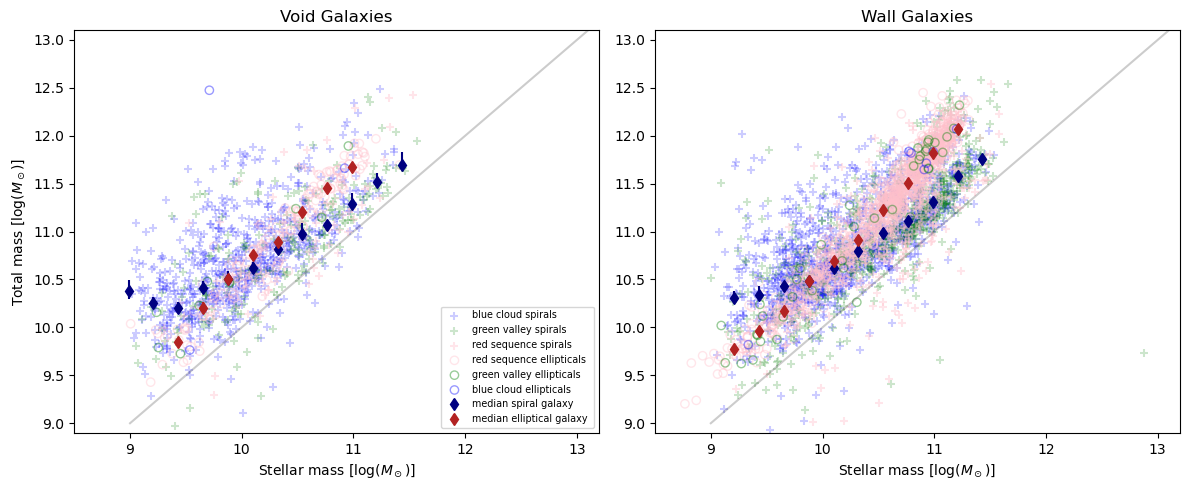

In [167]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

#labels

ax[0].set_title('Void Galaxies')
ax[1].set_title('Wall Galaxies')


ax[0].set_ylabel(r'Total mass [$\log(M_\odot)$]')
ax[0].set_xlabel(r'Stellar mass [$\log(M_\odot)$]')
ax[1].set_xlabel(r'Stellar mass [$\log(M_\odot)$]')


ax[1].set_ylim(8.9,13.1)
ax[0].set_ylim(8.9,13.1)
ax[1].set_xlim(8.5,13.2)
ax[0].set_xlim(8.5,13.2)

ax[0].plot([9,14],[9,14],color='k',alpha=0.2)
ax[1].plot([9,14],[9,14],color='k',alpha=0.2)

#void
ax[0].scatter(s_void[s_void['CMD_class'] == 1]['M90_disk'], s_void[s_void['CMD_class'] == 1]['M_R90'],
              color='b', alpha=0.2, marker='+',label='blue cloud spirals')
ax[0].scatter(s_void[s_void['CMD_class'] == 2]['M90_disk'], s_void[s_void['CMD_class'] == 2]['M_R90'],
              color='g', alpha=0.2, marker='+', label='green valley spirals')
ax[0].scatter(s_void[s_void['CMD_class'] == 3]['M90_disk'], s_void[s_void['CMD_class'] == 3]['M_R90'],
              color='pink', alpha=0.4, marker='+', label='red sequence spirals')

ax[0].scatter(np.log10(e_void[e_void['CMD_class'] == 3]['nsa_elpetro_mass']), e_void[e_void['CMD_class'] == 3]['Mvir'],
              color='pink', alpha=0.4, marker='o', label='red sequence ellipticals', facecolor='none')
ax[0].scatter(np.log10(e_void[e_void['CMD_class'] == 2]['nsa_elpetro_mass']), e_void[e_void['CMD_class'] == 2]['Mvir'],
              color='g', alpha=0.4, marker='o', label='green valley ellipticals', facecolor='none')
ax[0].scatter(np.log10(e_void[e_void['CMD_class'] == 1]['nsa_elpetro_mass']), e_void[e_void['CMD_class'] == 1]['Mvir'],
              color='b', alpha=0.4, marker='o', label='blue cloud ellipticals', facecolor='none')



#wall
ax[1].scatter(s_wall[s_wall['CMD_class'] == 1]['M90_disk'],s_wall[s_wall['CMD_class'] == 1]['M_R90'],
              color='b', alpha=0.2, marker='+')
ax[1].scatter(s_wall[s_wall['CMD_class'] == 2]['M90_disk'],s_wall[s_wall['CMD_class'] == 2]['M_R90'],
              color='g', alpha=0.2, marker='+')
ax[1].scatter(s_wall[s_wall['CMD_class'] == 3]['M90_disk'],s_wall[s_wall['CMD_class'] == 3]['M_R90'],
              color='pink', alpha=0.4, marker='+')

ax[1].scatter(np.log10(e_wall[e_wall['CMD_class'] == 3]['nsa_elpetro_mass']),e_wall[e_wall['CMD_class'] == 3]['Mvir'],
              color='pink', alpha=0.4, marker='o', label='red sequence', facecolor='none')
ax[1].scatter(np.log10(e_wall[e_wall['CMD_class'] == 2]['nsa_elpetro_mass']), e_wall[e_wall['CMD_class'] == 2]['Mvir'],
              color='g', alpha=0.4, marker='o', label='green valley', facecolor='none')
ax[1].scatter(np.log10(e_wall[e_wall['CMD_class'] == 1]['nsa_elpetro_mass']), e_wall[e_wall['CMD_class'] == 1]['Mvir'],
              color='b', alpha=0.4, marker='o', label='blue cloud', facecolor='none')

sp_void_mstar = med_percentile_scaled(s_void_mtot)
sp_wall_mstar = med_percentile_scaled(s_wall_mtot)
ep_void_mstar = med_percentile_scaled(e_void_mtot, True, True)
ep_wall_mstar = med_percentile_scaled(e_wall_mtot, True, True)

ax[0].errorbar(mstar_points, sp_void_mstar[:,0], color='navy', yerr=[sp_void_mstar[:,1] ,sp_void_mstar[:,2]], 
             marker='d', label='median spiral galaxy',linestyle='none', )

ax[0].errorbar(mstar_points, ep_void_mstar[:,0], color='firebrick', yerr=[ep_void_mstar[:,1] ,ep_void_mstar[:,2]], 
             marker='d', label='median elliptical galaxy ', linestyle='none', )


ax[1].errorbar(mstar_points, sp_wall_mstar[:,0], color='navy', yerr=[sp_wall_mstar[:,1] ,sp_wall_mstar[:,2]], 
             marker='d',linestyle='none')

ax[1].errorbar(mstar_points, ep_wall_mstar[:,0], color='firebrick', yerr=[ep_wall_mstar[:,1] ,ep_wall_mstar[:,2]], 
             marker='d', linestyle='none')


ax[0].legend(fontsize='x-small')

fig.tight_layout()
fig.savefig(plot_dir + 'env_stellar_total_mass_mstarbin.png')

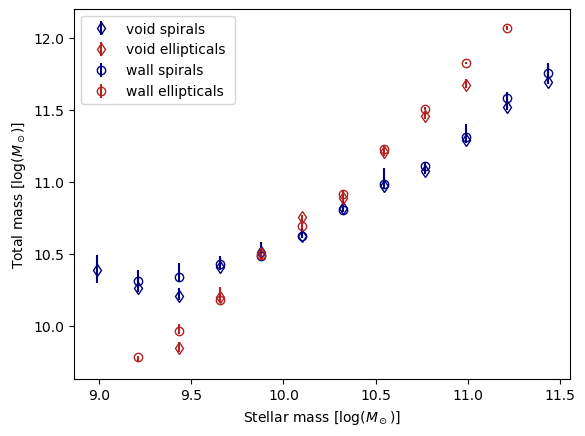

In [169]:
plt.errorbar(mstar_points, sp_void_mstar[:,0], color='navy', yerr=[sp_void_mstar[:,1] ,sp_void_mstar[:,2]], 
             marker='d', label='void spirals',linestyle='none', markerfacecolor='none' )

plt.errorbar(mstar_points, ep_void_mstar[:,0], color='firebrick', yerr=[ep_void_mstar[:,1] ,ep_void_mstar[:,2]], 
             marker='d', label='void ellipticals ', linestyle='none', markerfacecolor='none')


plt.errorbar(mstar_points, sp_wall_mstar[:,0], color='navy', yerr=[sp_wall_mstar[:,1] ,sp_wall_mstar[:,2]], 
             marker='o',linestyle='none', label='wall spirals', markerfacecolor='none')

plt.errorbar(mstar_points, ep_wall_mstar[:,0], color='firebrick', yerr=[ep_wall_mstar[:,1] ,ep_wall_mstar[:,2]], 
             marker='o', linestyle='none', label='wall ellipticals', markerfacecolor='none')


#plt.title('Median total mass')
plt.ylabel(r'Total mass [$\log(M_\odot)$]')
plt.xlabel(r'Stellar mass [$\log(M_\odot)]$')
#plt.yscale('log')
plt.legend()
#plt.ylim(8.5,12)
#plt.xlim(8,14)
plt.savefig(plot_dir + 'med_mstar_env_mstarbins.png')
plt.show()

### total mass vs mr colored by wall, void

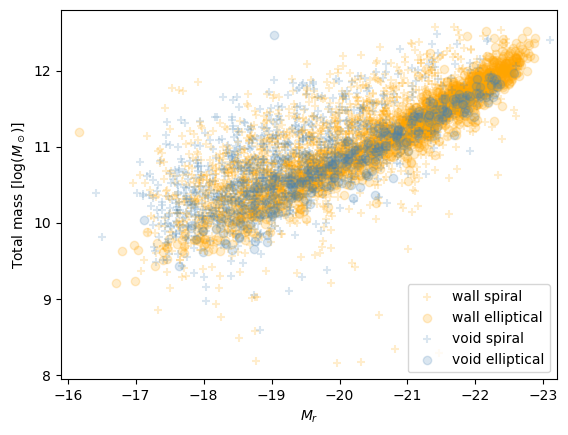

In [111]:
# distribution of all void and wall galaxies

plt.scatter(s_mag_wall,s_wall['M_R90'], color='orange', alpha=0.2, marker='+', label='wall spiral')
plt.scatter(e_mag_wall,e_wall['Mvir'], color='orange', alpha=0.2, marker='o', label='wall elliptical')
plt.scatter(s_mag_void,s_void['M_R90'], color='steelblue', alpha=0.2, marker='+', label='void spiral')
plt.scatter(e_mag_void,e_void['Mvir'], color='steelblue', alpha=0.2, marker='o', label='void elliptical')
plt.xlim(-15.9, -23.2)
plt.xlabel('$M_r$')
plt.ylabel(r'Total mass [$\log(M_\odot)$]')
plt.legend()
plt.savefig(plot_dir + 'all_void_wall.png')
plt.show()

### void vs. wall 3.5 R90 Mtot vs Mr

In [118]:
s_void_3p5_vals = []
e_void_3p5_vals = []
s_wall_3p5_vals = []
e_wall_3p5_vals = []

for i in range(len(points)):
    mag_lim = magnitude_bins[i+1]
    if i == 0:
        s_void_3p5_vals.append(s_void['M'][s_mag_void <= mag_lim])
        e_void_3p5_vals.append(e_void['Mvir'][e_mag_void <= mag_lim])
        s_wall_3p5_vals.append(s_wall['M'][s_mag_wall <= mag_lim])
        e_wall_3p5_vals.append(e_wall['Mvir'][e_mag_wall <= mag_lim])
    else:
        lower_lim = magnitude_bins[i]

        s_void_3p5_vals.append(s_void['M'][np.logical_and(s_mag_void <= mag_lim, s_mag_void > lower_lim)])
        e_void_3p5_vals.append(e_void['Mvir'][np.logical_and(e_mag_void <= mag_lim, e_mag_void > lower_lim)])
        s_wall_3p5_vals.append(s_wall['M'][np.logical_and(s_mag_wall <= mag_lim, s_mag_wall > lower_lim)])
        e_wall_3p5_vals.append(e_wall['Mvir'][np.logical_and(e_mag_wall <= mag_lim, e_mag_wall > lower_lim)])

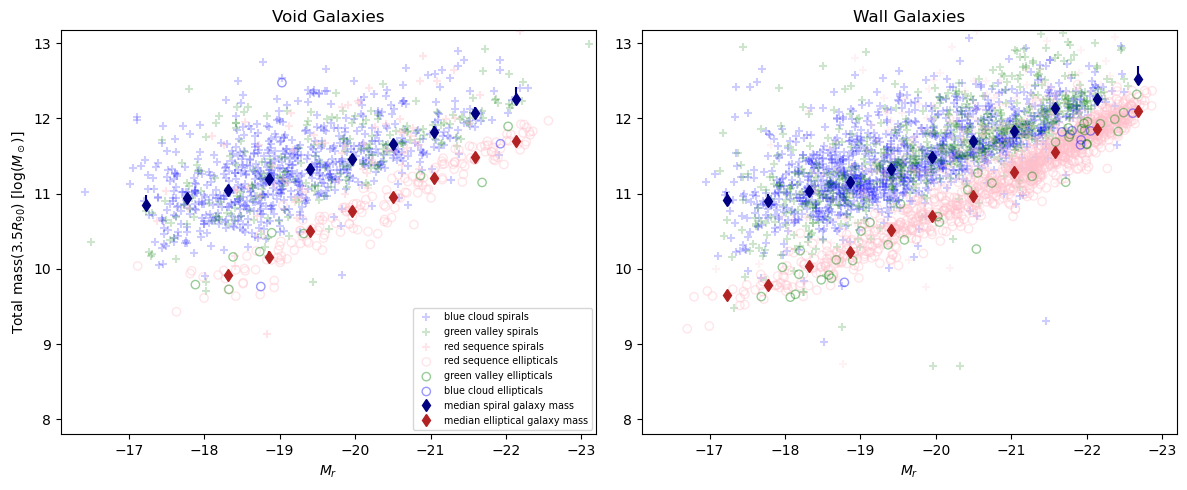

In [120]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

#labels

ax[0].set_title('Void Galaxies')
ax[1].set_title('Wall Galaxies')
ax[0].set_xlim(-16.1,-23.2)
ax[1].set_xlim(-16.1,-23.2)


ax[0].set_ylabel(r'Total mass(3.5$R_{90}$) [$\log(M_\odot)$]')
ax[0].set_xlabel('$M_r$')
ax[1].set_xlabel('$M_r$')
ax[0].set_ylim(np.min(spirals['M_R90'])-0.2,np.max(Mvir)+0.2)
ax[1].set_ylim(np.min(spirals['M_R90'])-0.2,np.max(Mvir)+0.2)


#void data
ax[0].scatter(s_mag_void[s_void['CMD_class'] == 1],s_void[s_void['CMD_class'] == 1]['M'],
              color='b', alpha=0.2, marker='+', label='blue cloud spirals')
ax[0].scatter(s_mag_void[s_void['CMD_class'] == 2],s_void[s_void['CMD_class'] == 2]['M'],
              color='g', alpha=0.2, marker='+', label='green valley spirals')
ax[0].scatter(s_mag_void[s_void['CMD_class'] == 3],s_void[s_void['CMD_class'] == 3]['M'],
              color='pink', alpha=0.4, marker='+', label='red sequence spirals')

ax[0].scatter(e_mag_void[e_void['CMD_class'] == 3],e_void[e_void['CMD_class'] == 3]['Mvir'],
              color='pink', alpha=0.4, marker='o', label='red sequence ellipticals', facecolor='none')
ax[0].scatter(e_mag_void[e_void['CMD_class'] == 2],e_void[e_void['CMD_class'] == 2]['Mvir'],
              color='g', alpha=0.4, marker='o', label='green valley ellipticals', facecolor='none')
ax[0].scatter(e_mag_void[e_void['CMD_class'] == 1],e_void[e_void['CMD_class'] == 1]['Mvir'],
              color='b', alpha=0.4, marker='o', label='blue cloud ellipticals', facecolor='none')

#wall data
ax[1].scatter(s_mag_wall[s_wall['CMD_class'] == 1],s_wall[s_wall['CMD_class'] == 1]['M'],
              color='b', alpha=0.2, marker='+')
ax[1].scatter(s_mag_wall[s_wall['CMD_class'] == 2],s_wall[s_wall['CMD_class'] == 2]['M'],
              color='g', alpha=0.2, marker='+')
ax[1].scatter(s_mag_wall[s_wall['CMD_class'] == 3],s_wall[s_wall['CMD_class'] == 3]['M'],
              color='pink', alpha=0.2, marker='+')

ax[1].scatter(e_mag_wall[e_wall['CMD_class'] == 3],e_wall[e_wall['CMD_class'] == 3]['Mvir'],
              color='pink', alpha=0.4, marker='o', label='red sequence', facecolor='none')
ax[1].scatter(e_mag_wall[e_wall['CMD_class'] == 2],e_wall[e_wall['CMD_class'] == 2]['Mvir'],
              color='g', alpha=0.4, marker='o', label='green valley', facecolor='none')
ax[1].scatter(e_mag_wall[e_wall['CMD_class'] == 1],e_wall[e_wall['CMD_class'] == 1]['Mvir'],
              color='b', alpha=0.4, marker='o', label='blue cloud', facecolor='none')



sp_void = med_percentile_scaled(s_void_3p5_vals)
sp_wall = med_percentile_scaled(s_wall_3p5_vals)
ep_void = med_percentile_scaled(e_void_3p5_vals)
ep_wall = med_percentile_scaled(e_wall_3p5_vals)

ax[0].errorbar(points, sp_void[:,0], color='navy', yerr=[sp_void[:,1] ,sp_void[:,2]], 
             marker='d', label='median spiral galaxy mass',linestyle='none')

ax[0].errorbar(points, ep_void[:,0], color='firebrick', yerr=[ep_void[:,1] ,ep_void[:,2]], 
             marker='d', label='median elliptical galaxy mass', linestyle='none')


ax[1].errorbar(points, sp_wall[:,0], color='navy', yerr=[sp_wall[:,1] ,sp_wall[:,2]], 
             marker='d',linestyle='none')

ax[1].errorbar(points, ep_wall[:,0], color='firebrick', yerr=[ep_wall[:,1] ,ep_wall[:,2]], 
             marker='d', linestyle='none')

ax[0].legend(fontsize='x-small')

fig.tight_layout()
fig.savefig(plot_dir + 'void_wall_all_err_3p5.png', )


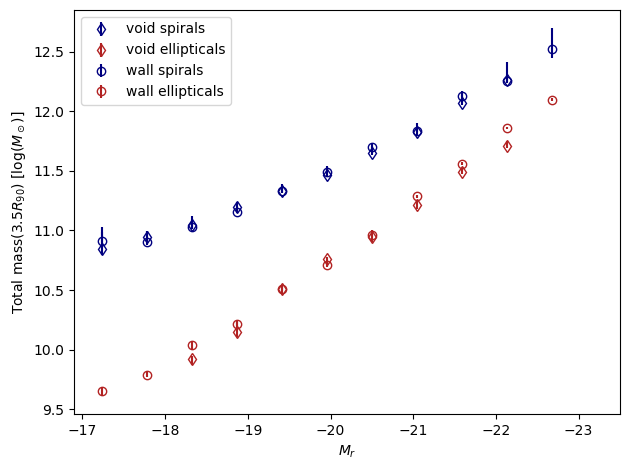

In [122]:
plt.errorbar(points, sp_void[:,0], color='navy', yerr=[sp_void[:,1] ,sp_void[:,2]], 
             marker='d', label='void spirals',linestyle='none', markerfacecolor='none')

plt.errorbar(points, ep_void[:,0], color='firebrick', yerr=[ep_void[:,1] ,ep_void[:,2]], 
             marker='d', label='void ellipticals', linestyle='none', markerfacecolor='none')


plt.errorbar(points, sp_wall[:,0], color='navy', yerr=[sp_wall[:,1] ,sp_wall[:,2]], 
             marker='o',label='wall spirals',linestyle='none', markerfacecolor='none')

plt.errorbar(points, ep_wall[:,0], color='firebrick', yerr=[ep_wall[:,1] ,ep_wall[:,2]], 
             marker='o',label='wall ellipticals', linestyle='none', markerfacecolor='none')

plt.xlabel('$M_r$')
plt.ylabel(r'Total mass(3.5$R_{90}$) [$\log(M_\odot)$]')
plt.legend()
plt.xlim(-16.9,-23.5)

plt.tight_layout()
plt.savefig(plot_dir + 'void_wall_all_err_med_3p5.png', )

### void vs. wall 3.5 R90 Mtot vs Mstar

In [127]:
tot_mass_bins_3p5 = np.linspace(np.min(s_wall['M']), np.max(s_wall['M']), 15)
tot_mass_points_3p5 = (tot_mass_bins_3p5[1:] + tot_mass_bins_3p5[:-1])/2

s_void_mstar_3p5 = []
e_void_mstar_3p5 = []

s_wall_mstar_3p5 = []
e_wall_mstar_3p5 = []

for i in range(len(tot_mass_points_3p5)):
    mass_lim = tot_mass_bins_3p5[i+1]
    if i == 0:
        e_void_mstar_3p5.append(e_void['nsa_elpetro_mass'][e_void['Mvir'] <= mass_lim])
        s_void_mstar_3p5.append(s_void['M_disk'][s_void['M'] <= mass_lim])
        e_wall_mstar_3p5.append(e_wall['nsa_elpetro_mass'][e_wall['Mvir'] <= mass_lim])
        s_wall_mstar_3p5.append(s_wall['M_disk'][s_wall['M'] <= mass_lim])

    else:
        lower_lim = tot_mass_bins_3p5[i]
        e_void_mstar_3p5.append(e_void['nsa_elpetro_mass'][np.logical_and(e_void['Mvir'] <= mass_lim, e_void['Mvir'] > lower_lim)])
        s_void_mstar_3p5.append(s_void['M_disk'][np.logical_and(s_void['M'] <= mass_lim, s_void['M'] > lower_lim)])
        e_wall_mstar_3p5.append(e_wall['nsa_elpetro_mass'][np.logical_and(e_wall['Mvir'] <= mass_lim, e_wall['Mvir'] > lower_lim)])
        s_wall_mstar_3p5.append(s_wall['M_disk'][np.logical_and(s_wall['M'] <= mass_lim, s_wall['M'] > lower_lim)])

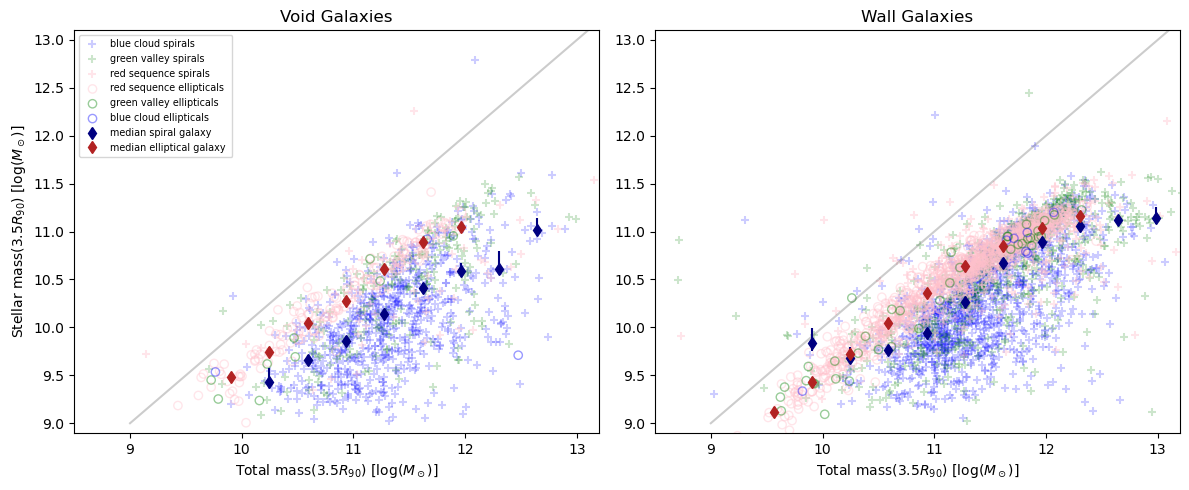

In [129]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

#labels

ax[0].set_title('Void Galaxies')
ax[1].set_title('Wall Galaxies')


ax[0].set_xlabel(r'Total mass(3.5$R_{90}$) [$\log(M_\odot)$]')
ax[1].set_xlabel(r'Total mass(3.5$R_{90}$) [$\log(M_\odot)$]')
ax[0].set_ylabel(r'Stellar mass(3.5$R_{90}$) [$\log(M_\odot)]$')

ax[0].set_ylim(8.9,13.1)
ax[1].set_ylim(8.9,13.1)
ax[0].set_xlim(8.5,13.2)
ax[1].set_xlim(8.5,13.2)

ax[0].plot([9,14],[9,14],color='k',alpha=0.2)
ax[1].plot([9,14],[9,14],color='k',alpha=0.2)

#void
ax[0].scatter(s_void[s_void['CMD_class'] == 1]['M'],s_void[s_void['CMD_class'] == 1]['M_disk'],
              color='b', alpha=0.2, marker='+',label='blue cloud spirals')
ax[0].scatter(s_void[s_void['CMD_class'] == 2]['M'],s_void[s_void['CMD_class'] == 2]['M_disk'],
              color='g', alpha=0.2, marker='+', label='green valley spirals')
ax[0].scatter(s_void[s_void['CMD_class'] == 3]['M'],s_void[s_void['CMD_class'] == 3]['M_disk'],
              color='pink', alpha=0.4, marker='+', label='red sequence spirals')

ax[0].scatter(e_void[e_void['CMD_class'] == 3]['Mvir'],np.log10(e_void[e_void['CMD_class'] == 3]['nsa_elpetro_mass']),
              color='pink', alpha=0.4, marker='o', label='red sequence ellipticals', facecolor='none')
ax[0].scatter(e_void[e_void['CMD_class'] == 2]['Mvir'],np.log10(e_void[e_void['CMD_class'] == 2]['nsa_elpetro_mass']),
              color='g', alpha=0.4, marker='o', label='green valley ellipticals', facecolor='none')
ax[0].scatter(e_void[e_void['CMD_class'] == 1]['Mvir'],np.log10(e_void[e_void['CMD_class'] == 1]['nsa_elpetro_mass']),
              color='b', alpha=0.4, marker='o', label='blue cloud ellipticals', facecolor='none')



#wall
ax[1].scatter(s_wall[s_wall['CMD_class'] == 1]['M'],s_wall[s_wall['CMD_class'] == 1]['M_disk'],
              color='b', alpha=0.2, marker='+')
ax[1].scatter(s_wall[s_wall['CMD_class'] == 2]['M'],s_wall[s_wall['CMD_class'] == 2]['M_disk'],
              color='g', alpha=0.2, marker='+')
ax[1].scatter(s_wall[s_wall['CMD_class'] == 3]['M'],s_wall[s_wall['CMD_class'] == 3]['M_disk'],
              color='pink', alpha=0.4, marker='+')

ax[1].scatter(e_wall[e_wall['CMD_class'] == 3]['Mvir'],np.log10(e_wall[e_wall['CMD_class'] == 3]['nsa_elpetro_mass']),
              color='pink', alpha=0.4, marker='o', label='red sequence', facecolor='none')
ax[1].scatter(e_wall[e_wall['CMD_class'] == 2]['Mvir'],np.log10(e_wall[e_wall['CMD_class'] == 2]['nsa_elpetro_mass']),
              color='g', alpha=0.4, marker='o', label='green valley', facecolor='none')
ax[1].scatter(e_wall[e_wall['CMD_class'] == 1]['Mvir'],np.log10(e_wall[e_wall['CMD_class'] == 1]['nsa_elpetro_mass']),
              color='b', alpha=0.4, marker='o', label='blue cloud', facecolor='none')

sp_void_mstar = med_percentile_scaled(s_void_mstar_3p5)
sp_wall_mstar = med_percentile_scaled(s_wall_mstar_3p5)
ep_void_mstar = med_percentile_scaled(e_void_mstar_3p5, False, True)
ep_wall_mstar = med_percentile_scaled(e_wall_mstar_3p5, False, True)

ax[0].errorbar(tot_mass_points_3p5, sp_void_mstar[:,0], color='navy', yerr=[sp_void_mstar[:,1] ,sp_void_mstar[:,2]], 
             marker='d', label='median spiral galaxy',linestyle='none', )

ax[0].errorbar(tot_mass_points_3p5, ep_void_mstar[:,0], color='firebrick', yerr=[ep_void_mstar[:,1] ,ep_void_mstar[:,2]], 
             marker='d', label='median elliptical galaxy ', linestyle='none', )


ax[1].errorbar(tot_mass_points_3p5, sp_wall_mstar[:,0], color='navy', yerr=[sp_wall_mstar[:,1] ,sp_wall_mstar[:,2]], 
             marker='d',linestyle='none')

ax[1].errorbar(tot_mass_points_3p5, ep_wall_mstar[:,0], color='firebrick', yerr=[ep_wall_mstar[:,1] ,ep_wall_mstar[:,2]], 
             marker='d', linestyle='none')


ax[0].legend(fontsize='x-small')

fig.tight_layout()
fig.savefig(plot_dir + 'env_stellar_total_mass_3p5.png')

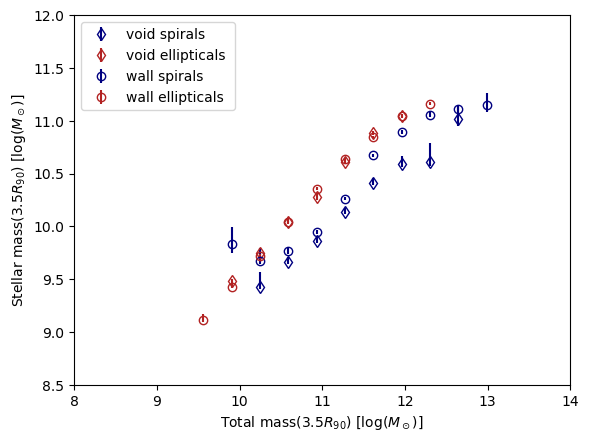

In [126]:
plt.errorbar(tot_mass_points_3p5, sp_void_mstar[:,0], color='navy', yerr=[sp_void_mstar[:,1] ,sp_void_mstar[:,2]], 
             marker='d', label='void spirals',linestyle='none', markerfacecolor='none' )

plt.errorbar(tot_mass_points_3p5, ep_void_mstar[:,0], color='firebrick', yerr=[ep_void_mstar[:,1] ,ep_void_mstar[:,2]], 
             marker='d', label='void ellipticals ', linestyle='none', markerfacecolor='none')


plt.errorbar(tot_mass_points_3p5, sp_wall_mstar[:,0], color='navy', yerr=[sp_wall_mstar[:,1] ,sp_wall_mstar[:,2]], 
             marker='o',linestyle='none', label='wall spirals', markerfacecolor='none')

plt.errorbar(tot_mass_points_3p5, ep_wall_mstar[:,0], color='firebrick', yerr=[ep_wall_mstar[:,1] ,ep_wall_mstar[:,2]], 
             marker='o', linestyle='none', label='wall ellipticals', markerfacecolor='none')


#plt.title('Median total mass')
plt.xlabel(r'Total mass(3.5$R_{90}$) [$\log(M_\odot)$]')
plt.ylabel(r'Stellar mass(3.5$R_{90}$) [$\log(M_\odot)]$')
#plt.yscale('log')
plt.legend()
plt.ylim(8.5,12)
plt.xlim(8,14)
plt.savefig(plot_dir + 'med_mstar_env_3p5.png')
plt.show()

### void vs. wall 3.5 R90 Mtot vs Mstar binned by Mstar

In [164]:
mstar_bins_3p5 = np.linspace(np.min([np.min(spirals['M_disk']) ,np.log10(np.min(ellipticals['nsa_elpetro_mass']))]),
                             np.max([np.max(spirals['M_disk']), np.log10(np.max(ellipticals['nsa_elpetro_mass']))]),
                             20)
                             


mstar_points_3p5 = (mstar_bins_3p5[1:] + mstar_bins_3p5[:-1])/2

s_void_mtot_3p5 = []
e_void_mtot_3p5 = []

s_wall_mtot_3p5 = []
e_wall_mtot_3p5 = []

for i in range(len(mstar_points_3p5)):
    mass_lim = mstar_bins_3p5[i+1]
    if i == 0:
        e_void_mtot_3p5.append(e_void['Mvir'][np.log10(e_void['nsa_elpetro_mass']) <= mass_lim])
        s_void_mtot_3p5.append(s_void['M'][s_void['M_disk'] <= mass_lim])
        e_wall_mtot_3p5.append(e_wall['Mvir'][np.log10(e_wall['nsa_elpetro_mass']) <= mass_lim])
        s_wall_mtot_3p5.append(s_wall['M'][s_wall['M_disk'] <= mass_lim])

    else:
        lower_lim = mstar_bins_3p5[i]
        e_void_mtot_3p5.append(e_void['Mvir'][np.logical_and(np.log10(e_void['nsa_elpetro_mass']) <= mass_lim,
                                                             np.log10(e_void['nsa_elpetro_mass']) > lower_lim)])
        s_void_mtot_3p5.append(s_void['M'][np.logical_and(s_void['M_disk'] <= mass_lim, s_void['M_disk'] > lower_lim)])
        e_wall_mtot_3p5.append(e_wall['Mvir'][np.logical_and(np.log10(e_wall['nsa_elpetro_mass']) <= mass_lim, 
                                                             np.log10(e_wall['nsa_elpetro_mass']) > lower_lim)])
        s_wall_mtot_3p5.append(s_wall['M'][np.logical_and(s_wall['M_disk'] <= mass_lim, s_wall['M_disk'] > lower_lim)])

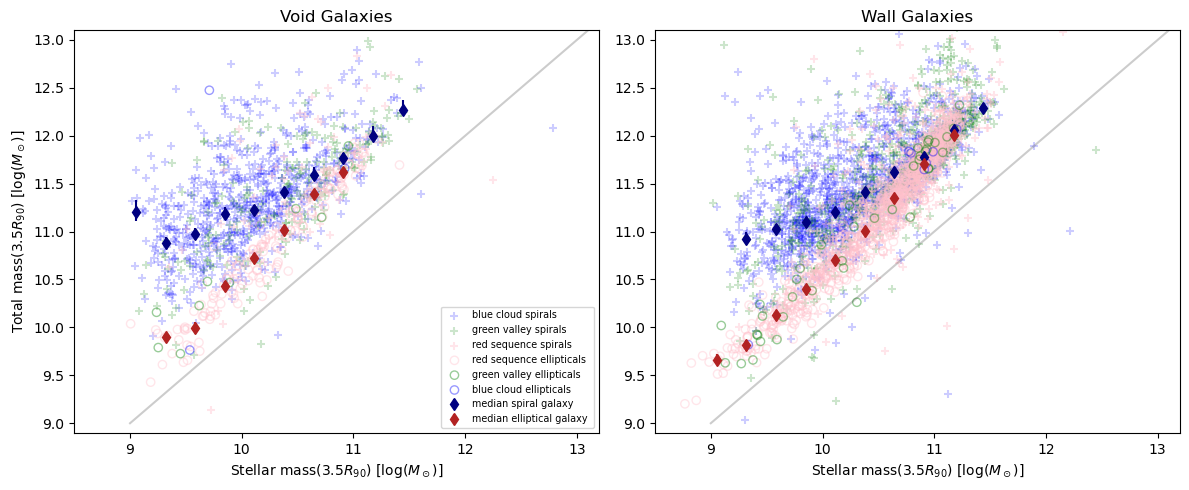

In [165]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

#labels

ax[0].set_title('Void Galaxies')
ax[1].set_title('Wall Galaxies')


ax[0].set_ylabel(r'Total mass(3.5$R_{90}$) [$\log(M_\odot)$]')
ax[0].set_xlabel(r'Stellar mass(3.5$R_{90}$) [$\log(M_\odot)$]')
ax[1].set_xlabel(r'Stellar mass(3.5$R_{90}$) [$\log(M_\odot)$]')


ax[1].set_ylim(8.9,13.1)
ax[0].set_ylim(8.9,13.1)
ax[1].set_xlim(8.5,13.2)
ax[0].set_xlim(8.5,13.2)

ax[0].plot([9,14],[9,14],color='k',alpha=0.2)
ax[1].plot([9,14],[9,14],color='k',alpha=0.2)

#void
ax[0].scatter(s_void[s_void['CMD_class'] == 1]['M_disk'], s_void[s_void['CMD_class'] == 1]['M'],
              color='b', alpha=0.2, marker='+',label='blue cloud spirals')
ax[0].scatter(s_void[s_void['CMD_class'] == 2]['M_disk'], s_void[s_void['CMD_class'] == 2]['M'],
              color='g', alpha=0.2, marker='+', label='green valley spirals')
ax[0].scatter(s_void[s_void['CMD_class'] == 3]['M_disk'], s_void[s_void['CMD_class'] == 3]['M'],
              color='pink', alpha=0.4, marker='+', label='red sequence spirals')

ax[0].scatter(np.log10(e_void[e_void['CMD_class'] == 3]['nsa_elpetro_mass']), e_void[e_void['CMD_class'] == 3]['Mvir'],
              color='pink', alpha=0.4, marker='o', label='red sequence ellipticals', facecolor='none')
ax[0].scatter(np.log10(e_void[e_void['CMD_class'] == 2]['nsa_elpetro_mass']), e_void[e_void['CMD_class'] == 2]['Mvir'],
              color='g', alpha=0.4, marker='o', label='green valley ellipticals', facecolor='none')
ax[0].scatter(np.log10(e_void[e_void['CMD_class'] == 1]['nsa_elpetro_mass']), e_void[e_void['CMD_class'] == 1]['Mvir'],
              color='b', alpha=0.4, marker='o', label='blue cloud ellipticals', facecolor='none')



#wall
ax[1].scatter(s_wall[s_wall['CMD_class'] == 1]['M_disk'],s_wall[s_wall['CMD_class'] == 1]['M'],
              color='b', alpha=0.2, marker='+')
ax[1].scatter(s_wall[s_wall['CMD_class'] == 2]['M_disk'],s_wall[s_wall['CMD_class'] == 2]['M'],
              color='g', alpha=0.2, marker='+')
ax[1].scatter(s_wall[s_wall['CMD_class'] == 3]['M_disk'],s_wall[s_wall['CMD_class'] == 3]['M'],
              color='pink', alpha=0.4, marker='+')

ax[1].scatter(np.log10(e_wall[e_wall['CMD_class'] == 3]['nsa_elpetro_mass']),e_wall[e_wall['CMD_class'] == 3]['Mvir'],
              color='pink', alpha=0.4, marker='o', label='red sequence', facecolor='none')
ax[1].scatter(np.log10(e_wall[e_wall['CMD_class'] == 2]['nsa_elpetro_mass']), e_wall[e_wall['CMD_class'] == 2]['Mvir'],
              color='g', alpha=0.4, marker='o', label='green valley', facecolor='none')
ax[1].scatter(np.log10(e_wall[e_wall['CMD_class'] == 1]['nsa_elpetro_mass']), e_wall[e_wall['CMD_class'] == 1]['Mvir'],
              color='b', alpha=0.4, marker='o', label='blue cloud', facecolor='none')

sp_void_mstar = med_percentile_scaled(s_void_mtot_3p5)
sp_wall_mstar = med_percentile_scaled(s_wall_mtot_3p5)
ep_void_mstar = med_percentile_scaled(e_void_mtot_3p5, True, True)
ep_wall_mstar = med_percentile_scaled(e_wall_mtot_3p5, True, True)

ax[0].errorbar(mstar_points_3p5, sp_void_mstar[:,0], color='navy', yerr=[sp_void_mstar[:,1] ,sp_void_mstar[:,2]], 
             marker='d', label='median spiral galaxy',linestyle='none', )

ax[0].errorbar(mstar_points_3p5, ep_void_mstar[:,0], color='firebrick', yerr=[ep_void_mstar[:,1] ,ep_void_mstar[:,2]], 
             marker='d', label='median elliptical galaxy ', linestyle='none', )


ax[1].errorbar(mstar_points_3p5, sp_wall_mstar[:,0], color='navy', yerr=[sp_wall_mstar[:,1] ,sp_wall_mstar[:,2]], 
             marker='d',linestyle='none')

ax[1].errorbar(mstar_points_3p5, ep_wall_mstar[:,0], color='firebrick', yerr=[ep_wall_mstar[:,1] ,ep_wall_mstar[:,2]], 
             marker='d', linestyle='none')


ax[0].legend(fontsize='x-small')

fig.tight_layout()
fig.savefig(plot_dir + 'env_stellar_total_mass_3p5_mstarbin.png')

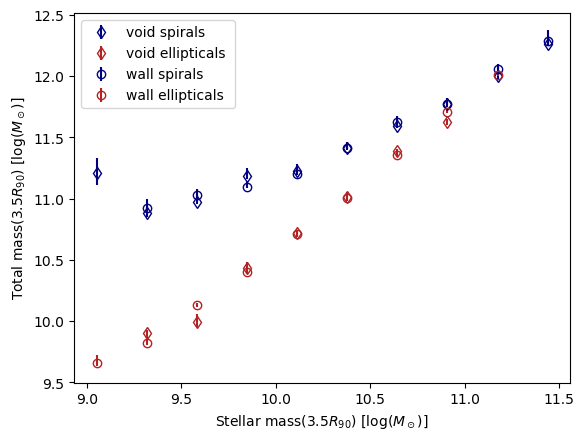

In [166]:
plt.errorbar(mstar_points_3p5, sp_void_mstar[:,0], color='navy', yerr=[sp_void_mstar[:,1] ,sp_void_mstar[:,2]], 
             marker='d', label='void spirals',linestyle='none', markerfacecolor='none' )

plt.errorbar(mstar_points_3p5, ep_void_mstar[:,0], color='firebrick', yerr=[ep_void_mstar[:,1] ,ep_void_mstar[:,2]], 
             marker='d', label='void ellipticals ', linestyle='none', markerfacecolor='none')


plt.errorbar(mstar_points_3p5, sp_wall_mstar[:,0], color='navy', yerr=[sp_wall_mstar[:,1] ,sp_wall_mstar[:,2]], 
             marker='o',linestyle='none', label='wall spirals', markerfacecolor='none')

plt.errorbar(mstar_points_3p5, ep_wall_mstar[:,0], color='firebrick', yerr=[ep_wall_mstar[:,1] ,ep_wall_mstar[:,2]], 
             marker='o', linestyle='none', label='wall ellipticals', markerfacecolor='none')


#plt.title('Median total mass')
plt.ylabel(r'Total mass(3.5$R_{90}$) [$\log(M_\odot)$]')
plt.xlabel(r'Stellar mass(3.5$R_{90}$) [$\log(M_\odot)]$')
#plt.yscale('log')
plt.legend()
#plt.ylim(8.5,12)
#plt.xlim(8,14)
plt.savefig(plot_dir + 'med_mstar_env_3p5_mstarbins.png')
plt.show()

## Mvis vs. Mtot plots

In [45]:
spirals_HI_R90 = spirals[spirals['logHI_R90']>0]
spirals_HI = spirals[spirals['logHI']>0]
ellipticals_HI = ellipticals[ellipticals['logHI']>0]
ellipticals_HI_lim = ellipticals[ellipticals['logHIlim']>0]

### Spiral mvis = Mstar(R90) + MHI (R90); Elliptical Mvis = Mstar

In [46]:
tot_mass_bins = np.linspace(np.min(spirals_HI_R90['M_R90']), np.max(ellipticals['Mvir']), 15)
tot_mass_points = (tot_mass_bins[1:] + tot_mass_bins[:-1])/2

spirals_HI_R90_mvis = []
ellipticals_mstar = []

for i in range(len(tot_mass_points)):
    mass_lim = tot_mass_bins[i+1]
    if i == 0:
        spirals_HI_R90_mvis.append(np.log10(10**spirals_HI_R90['logHI_R90'][spirals_HI_R90['M_R90'] <= mass_lim] + 10**spirals_HI_R90['M90_disk'][spirals_HI_R90['M_R90'] <= mass_lim]))
        ellipticals_mstar.append(ellipticals['nsa_elpetro_mass'][ellipticals['Mvir'] <= mass_lim])

    else:
        lower_lim = tot_mass_bins[i]
        ellipticals_mstar.append(ellipticals['nsa_elpetro_mass'][np.logical_and(ellipticals['Mvir'] <= mass_lim, ellipticals['Mvir'] > lower_lim)])
        spirals_HI_R90_mvis.append(np.log10(10**spirals_HI_R90['M90_disk'][np.logical_and(spirals_HI_R90['M_R90'] <= mass_lim, spirals_HI_R90['M_R90'] > lower_lim)] +\
                                            10**spirals_HI_R90['logHI_R90'][np.logical_and(spirals_HI_R90['M_R90'] <= mass_lim, spirals_HI_R90['M_R90'] > lower_lim)])
        )

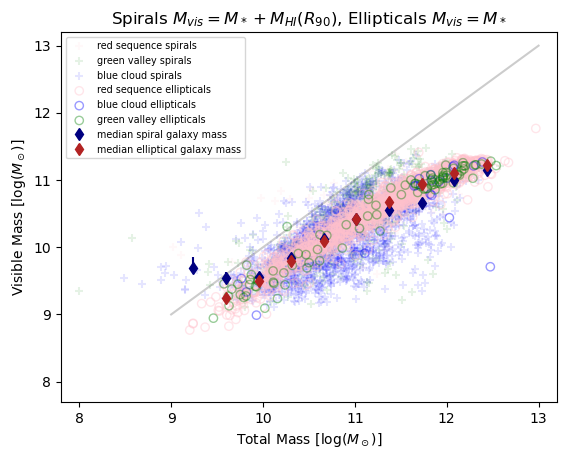

In [47]:
plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['logHI_R90']),
            alpha=0.1, color='pink', marker='+', label = 'red sequence spirals')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['logHI_R90']),
            alpha=0.1, color='g', marker='+', label='green valley spirals')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['logHI_R90']),
            alpha=0.1, color='b', marker='+', label='blue cloud spirals')


plt.scatter(Mvir[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3],
            alpha=0.4, color = 'pink', label='red sequence ellipticals', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1],
            color = 'b', alpha=0.4, label='blue cloud ellipticals', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2],
            alpha=0.4, color = 'g', label='green valley ellipticals', facecolor='none')


ep = med_percentile_scaled(ellipticals_mstar, False, True)
sp = med_percentile_scaled(spirals_HI_R90_mvis)


plt.errorbar(tot_mass_points, sp[:,0], color='navy', yerr=[sp[:,1] ,sp[:,2]], 
             marker='d', label='median spiral galaxy mass',linestyle='none')

plt.errorbar(tot_mass_points, ep[:,0], color='firebrick', yerr=[ep[:,1] ,ep[:,2]], 
             marker='d', label='median elliptical galaxy mass', linestyle='none')



plt.legend(fontsize='x-small')
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Visible Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.title(r'Spirals $M_{vis} = M_* + M_{HI}(R_{90})$, Ellipticals $M_{vis}=M_*$')
plt.ylim(7.7,13.2)
plt.xlim(7.8,13.2)
plt.savefig(plot_dir + 'Mvis1.png')
plt.show()

### Spirals Mvis = Mstar(R90) + MHI(R90); Ellipticals Mvis = Mstar + MHI

In [48]:
ellipticals_mvis = []

for i in range(len(tot_mass_points)):
    mass_lim = tot_mass_bins[i+1]
    if i == 0:
        ellipticals_mvis.append(ellipticals_HI['nsa_elpetro_mass'][ellipticals_HI['Mvir'] <= mass_lim] \
                                + 10**ellipticals_HI['logHI'][ellipticals_HI['Mvir'] <= mass_lim])

    else:
        lower_lim = tot_mass_bins[i]
        ellipticals_mvis.append(ellipticals_HI['nsa_elpetro_mass'][np.logical_and(ellipticals_HI['Mvir'] <= mass_lim, ellipticals_HI['Mvir'] > lower_lim)]\
                                + 10**ellipticals_HI['logHI'][np.logical_and(ellipticals_HI['Mvir'] <= mass_lim, ellipticals_HI['Mvir'] > lower_lim)])

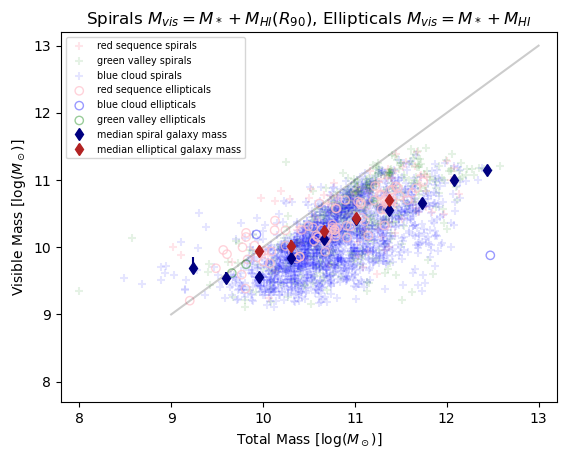

In [49]:
plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['logHI_R90']),
            alpha=0.4, color='pink', marker='+', label='red sequence spirals')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['logHI_R90']),
            alpha=0.1, color='g', marker='+', label='green valley spirals')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['logHI_R90']),
            alpha=0.1, color='b', marker='+', label='blue cloud spirals')


plt.scatter(ellipticals_HI[ellipticals_HI['CMD_class'] == 3]['Mvir'], 
            np.log10(ellipticals_HI[ellipticals_HI['CMD_class'] == 3]['nsa_elpetro_mass']+10**ellipticals_HI[ellipticals_HI['CMD_class'] == 3]['logHI']),
            alpha=0.7, color = 'pink', label='red sequence ellipticals', facecolor='none')
plt.scatter(ellipticals_HI[ellipticals_HI['CMD_class'] == 1]['Mvir'], 
            np.log10(ellipticals_HI[ellipticals_HI['CMD_class'] == 1]['nsa_elpetro_mass']+10**ellipticals_HI[ellipticals_HI['CMD_class'] == 1]['logHI']),
            color = 'b', alpha=0.4, label='blue cloud ellipticals', facecolor='none')
plt.scatter(ellipticals_HI[ellipticals_HI['CMD_class'] == 2]['Mvir'], 
            np.log10(ellipticals_HI[ellipticals_HI['CMD_class'] == 2]['nsa_elpetro_mass']+10**ellipticals_HI[ellipticals_HI['CMD_class'] == 2]['logHI']),
            alpha=0.4, color = 'g', label='green valley ellipticals', facecolor='none')


ep = med_percentile_scaled(ellipticals_mvis, False, True)

plt.errorbar(tot_mass_points, sp[:,0], color='navy', yerr=[sp[:,1] ,sp[:,2]], 
             marker='d', label='median spiral galaxy mass',linestyle='none')

plt.errorbar(tot_mass_points, ep[:,0], color='firebrick', yerr=[ep[:,1] ,ep[:,2]], 
             marker='d', label='median elliptical galaxy mass', linestyle='none')



plt.legend(fontsize='x-small')
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Visible Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.ylim(7.7,13.2)
plt.xlim(7.8,13.2)
plt.title(r'Spirals $M_{vis} = M_* + M_{HI}(R_{90})$, Ellipticals $M_{vis}=M_* + M_{HI}$')
plt.savefig(plot_dir + 'Mvis2.png')
plt.show()

### Spirals Mvis = Mstar(R90) + MHI(R90); Ellipticals Mvis = Mstar + MHIlim

In [51]:
ellipticals_mvis_lim = []

for i in range(len(tot_mass_points)):
    mass_lim = tot_mass_bins[i+1]
    if i == 0:
        ellipticals_mvis_lim.append(ellipticals_HI_lim['nsa_elpetro_mass'][ellipticals_HI_lim['Mvir'] <= mass_lim] \
                                + 10**ellipticals_HI_lim['logHIlim'][ellipticals_HI_lim['Mvir'] <= mass_lim])

    else:
        lower_lim = tot_mass_bins[i]
        ellipticals_mvis_lim.append(ellipticals_HI_lim['nsa_elpetro_mass'][np.logical_and(ellipticals_HI_lim['Mvir'] <= mass_lim, ellipticals_HI_lim['Mvir'] > lower_lim)]\
                                + 10**ellipticals_HI_lim['logHIlim'][np.logical_and(ellipticals_HI_lim['Mvir'] <= mass_lim, ellipticals_HI_lim['Mvir'] > lower_lim)])

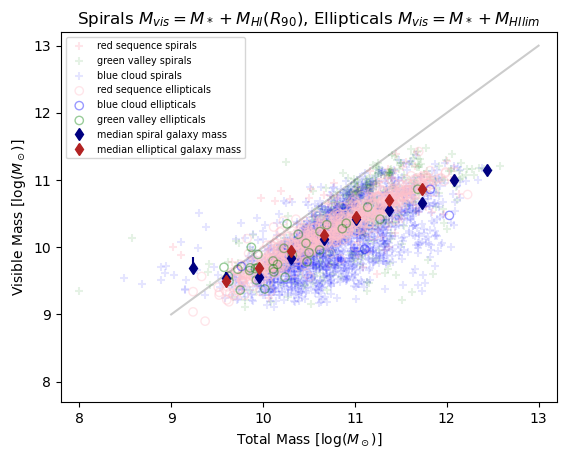

In [52]:
plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['logHI_R90']),
            alpha=0.4, color='pink', marker='+', label='red sequence spirals')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['logHI_R90']),
            alpha=0.1, color='g', marker='+', label='green valley spirals')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['logHI_R90']),
            alpha=0.1, color='b', marker='+', label='blue cloud spirals')


plt.scatter(ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 3]['Mvir'], 
            np.log10(ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 3]['nsa_elpetro_mass']+
                     10**ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 3]['logHIlim']),
            alpha=0.4, color = 'pink', label='red sequence ellipticals', facecolor='none')
plt.scatter(ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 1]['Mvir'], 
            np.log10(ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 1]['nsa_elpetro_mass']+
                     10**ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 1]['logHIlim']),
            color = 'b', alpha=0.4, label='blue cloud ellipticals', facecolor='none')
plt.scatter(ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 2]['Mvir'], 
            np.log10(ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 2]['nsa_elpetro_mass']+
                     10**ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 2]['logHIlim']),
            alpha=0.4, color = 'g', label='green valley ellipticals', facecolor='none')

ep = med_percentile_scaled(ellipticals_mvis_lim, False, True)

plt.errorbar(tot_mass_points, sp[:,0], color='navy', yerr=[sp[:,1] ,sp[:,2]], 
             marker='d', label='median spiral galaxy mass',linestyle='none')

plt.errorbar(tot_mass_points, ep[:,0], color='firebrick', yerr=[ep[:,1] ,ep[:,2]], 
             marker='d', label='median elliptical galaxy mass', linestyle='none')

plt.legend(fontsize='x-small')
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Visible Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.ylim(7.7,13.2)
plt.xlim(7.8,13.2)
plt.title(r'Spirals $M_{vis} = M_* + M_{HI}(R_{90})$, Ellipticals $M_{vis}=M_* + M_{HIlim}$')
plt.savefig(plot_dir + 'Mvis3.png')
plt.show()

### Spirals Mvis = Mstar(R90) + MHI; Ellipticals Mvis = Mstar

In [53]:
spirals_HI_mvis = []

for i in range(len(tot_mass_points)):
    mass_lim = tot_mass_bins[i+1]
    if i == 0:
        spirals_HI_mvis.append(np.log10(10**spirals_HI_R90['logHI'][spirals_HI_R90['M_R90'] <= mass_lim] + 10**spirals_HI_R90['M90_disk'][spirals_HI_R90['M_R90'] <= mass_lim]))
        
    else:
        lower_lim = tot_mass_bins[i]
        spirals_HI_mvis.append(np.log10(10**spirals_HI_R90['M90_disk'][np.logical_and(spirals_HI_R90['M_R90'] <= mass_lim, spirals_HI_R90['M_R90'] > lower_lim)] +\
                                            10**spirals_HI_R90['logHI'][np.logical_and(spirals_HI_R90['M_R90'] <= mass_lim, spirals_HI_R90['M_R90'] > lower_lim)])
        )

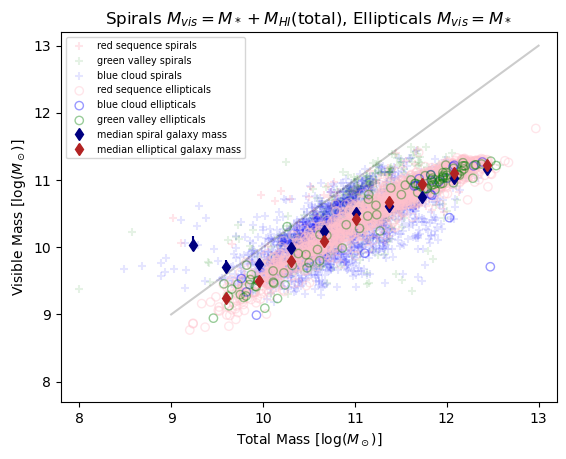

In [54]:
plt.scatter(spirals_HI[spirals_HI['CMD_class']==3]['M_R90'],
            np.log10(10**spirals_HI[spirals_HI['CMD_class']==3]['M90_disk']+10**spirals_HI[spirals_HI['CMD_class']==3]['logHI']),
            alpha=0.4, color='pink', marker='+', label= 'red sequence spirals')

plt.scatter(spirals_HI[spirals_HI['CMD_class']==2]['M_R90'],
            np.log10(10**spirals_HI[spirals_HI['CMD_class']==2]['M90_disk']+10**spirals_HI[spirals_HI['CMD_class']==2]['logHI']),
            alpha=0.1, color='g', marker='+', label='green valley spirals')

plt.scatter(spirals_HI[spirals_HI['CMD_class']==1]['M_R90'],
            np.log10(10**spirals_HI[spirals_HI['CMD_class']==1]['M90_disk']+10**spirals_HI[spirals_HI['CMD_class']==1]['logHI']),
            alpha=0.1, color='b', marker='+', label='blue cloud spirals')


plt.scatter(Mvir[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3],
            alpha=0.4, color = 'pink', label='red sequence ellipticals', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1],
            color = 'b', alpha=0.4, label='blue cloud ellipticals', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2],
            alpha=0.4, color = 'g', label='green valley ellipticals', facecolor='none')

ep = med_percentile_scaled(ellipticals_mstar, False, True)
sp = med_percentile_scaled(spirals_HI_mvis)

plt.errorbar(tot_mass_points, sp[:,0], color='navy', yerr=[sp[:,1] ,sp[:,2]], 
             marker='d', label='median spiral galaxy mass',linestyle='none')

plt.errorbar(tot_mass_points, ep[:,0], color='firebrick', yerr=[ep[:,1] ,ep[:,2]], 
             marker='d', label='median elliptical galaxy mass', linestyle='none')

plt.legend(fontsize='x-small')
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Visible Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.xlim(7.8,13.2)
plt.ylim(7.7,13.2)
plt.title(r'Spirals $M_{vis} = M_* + M_{HI}$(total), Ellipticals $M_{vis}=M_*$')
plt.savefig(plot_dir + 'Mvis4.png')
plt.show()

### Spirals Mvis = Mstar(3.5 R90) + MHI; Ellipticals Mvis = Mstar

In [55]:
tot_mass_bins = np.linspace(np.min(spirals_HI['M']), np.max(spirals_HI['M']), 15)
tot_mass_points = (tot_mass_bins[1:] + tot_mass_bins[:-1])/2

spirals_HI_mvis_3p5 = []
ellipticals_mstar_3p5 = []

for i in range(len(tot_mass_points)):
    mass_lim = tot_mass_bins[i+1]
    if i == 0:
        spirals_HI_mvis_3p5.append(np.log10(10**spirals_HI['logHI'][spirals_HI_R90['M'] <= mass_lim] + 10**spirals_HI_R90['M_disk'][spirals_HI_R90['M'] <= mass_lim]))
        ellipticals_mstar_3p5.append(ellipticals['nsa_elpetro_mass'][ellipticals['Mvir'] <= mass_lim])

    else:
        lower_lim = tot_mass_bins[i]
        ellipticals_mstar_3p5.append(ellipticals['nsa_elpetro_mass'][np.logical_and(ellipticals['Mvir'] <= mass_lim, ellipticals['Mvir'] > lower_lim)])
        spirals_HI_mvis_3p5.append(np.log10(10**spirals_HI_R90['M_disk'][np.logical_and(spirals_HI_R90['M'] <= mass_lim, spirals_HI_R90['M'] > lower_lim)] +\
                                            10**spirals_HI_R90['logHI'][np.logical_and(spirals_HI_R90['M'] <= mass_lim, spirals_HI_R90['M'] > lower_lim)])
        )

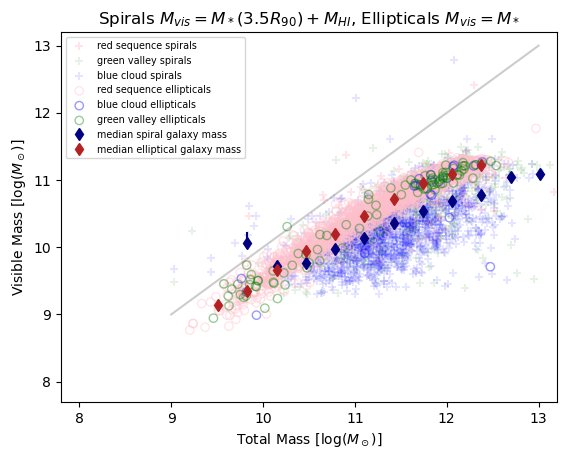

In [56]:
plt.scatter(spirals_HI[spirals_HI['CMD_class']==3]['M'],
            np.log10(10**spirals_HI[spirals_HI['CMD_class']==3]['M_disk']+10**spirals_HI[spirals_HI['CMD_class']==3]['logHI']),
            alpha=0.4, color='pink', marker='+', label='red sequence spirals')

plt.scatter(spirals_HI[spirals_HI['CMD_class']==2]['M'],
            np.log10(10**spirals_HI[spirals_HI['CMD_class']==2]['M_disk']+10**spirals_HI[spirals_HI['CMD_class']==2]['logHI']),
            alpha=0.1, color='g', marker='+', label='green valley spirals')

plt.scatter(spirals_HI[spirals_HI['CMD_class']==1]['M'],
            np.log10(10**spirals_HI[spirals_HI['CMD_class']==1]['M_disk']+10**spirals_HI[spirals_HI['CMD_class']==1]['logHI']),
            alpha=0.1, color='b', marker='+', label='blue cloud spirals')


plt.scatter(Mvir[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3],
            alpha=0.4, color = 'pink', label='red sequence ellipticals', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1],
            color = 'b', alpha=0.4, label='blue cloud ellipticals', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2],
            alpha=0.4, color = 'g', label='green valley ellipticals', facecolor='none')

ep = med_percentile_scaled(ellipticals_mstar_3p5, False, True)
sp = med_percentile_scaled(spirals_HI_mvis_3p5)

plt.errorbar(tot_mass_points, sp[:,0], color='navy', yerr=[sp[:,1] ,sp[:,2]], 
             marker='d', label='median spiral galaxy mass',linestyle='none')

plt.errorbar(tot_mass_points, ep[:,0], color='firebrick', yerr=[ep[:,1] ,ep[:,2]], 
             marker='d', label='median elliptical galaxy mass', linestyle='none')

plt.legend(fontsize='x-small')
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Visible Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.xlim(7.8,13.2)
plt.ylim(7.7,13.2)
plt.title(r'Spirals $M_{vis} = M_*(3.5R_{90}) + M_{HI}$, Ellipticals $M_{vis}=M_*$')
plt.savefig(plot_dir + 'Mvis5.png')
plt.show()

### Spirals Mvis = Mstar(R90); Ellipticals Mvis = Mstar

In [61]:
tot_mass_bins = np.linspace(np.min(spirals_HI_R90['M_R90']), np.max(ellipticals['Mvir']), 15)
tot_mass_points = (tot_mass_bins[1:] + tot_mass_bins[:-1])/2

spirals_HI_R90_mstar = []
ellipticals_mstar = []

for i in range(len(tot_mass_points)):
    mass_lim = tot_mass_bins[i+1]
    if i == 0:
        spirals_HI_R90_mstar.append(spirals_HI_R90['M90_disk'][spirals_HI_R90['M_R90'] <= mass_lim])
        ellipticals_mstar.append(ellipticals['nsa_elpetro_mass'][ellipticals['Mvir'] <= mass_lim])
        
    else:
        lower_lim = tot_mass_bins[i]
        spirals_HI_R90_mstar.append(spirals_HI_R90['M90_disk'][np.logical_and(spirals_HI_R90['M_R90'] <= mass_lim, spirals_HI_R90['M_R90'] > lower_lim)])
        ellipticals_mstar.append(ellipticals['nsa_elpetro_mass'][np.logical_and(ellipticals['Mvir'] <= mass_lim, ellipticals['Mvir'] > lower_lim )])

/Users/nityaravi/miniforge3/envs/RotationCurves/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


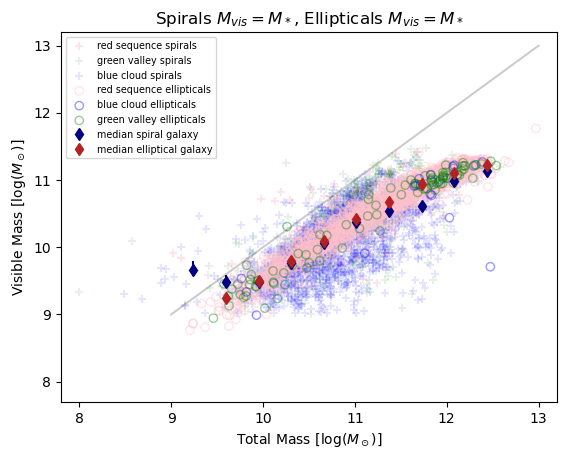

In [62]:
plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M_R90'],
            spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M90_disk'],
            alpha=0.4, color='pink', marker='+', label='red sequence spirals')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M_R90'],
            spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M90_disk'],
            alpha=0.1, color='g', marker='+', label='green valley spirals')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M_R90'],
            spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M90_disk'],
            alpha=0.1, color='b', marker='+', label='blue cloud spirals')


plt.scatter(Mvir[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3],
            alpha=0.4, color = 'pink', label='red sequence ellipticals', facecolor='none',)
plt.scatter(Mvir[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1],
            color = 'b', alpha=0.4, label='blue cloud ellipticals', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2],
            alpha=0.4, color = 'g', label='green valley ellipticals', facecolor='none')



sp = med_percentile_scaled(spirals_HI_R90_mstar)

ep = med_percentile_scaled(ellipticals_mstar, False, True)


plt.errorbar(tot_mass_points, sp[:,0], color='navy', yerr=[sp[:,1] ,sp[:,2]], 
             marker='d', label='median spiral galaxy',linestyle='none')

plt.errorbar(tot_mass_points, ep[:,0], color='firebrick', yerr=[ep[:,1] ,ep[:,2]], 
             marker='d', label='median elliptical galaxy', linestyle='none')

plt.legend(fontsize='x-small')
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Visible Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.title(r'Spirals $M_{vis} = M_*$, Ellipticals $M_{vis}=M_*$')
plt.ylim(7.7,13.2)
plt.xlim(7.8,13.2)
plt.savefig(plot_dir + 'Mvis6.png')
plt.show()

## Histograms

### Pipe3D vs DAP velocity disperison

In [63]:
Pipe3D_sigma_table = Table.read('/Users/nityaravi/Documents/Research/RotationCurves/data/manga/output_files/DR17/CURRENT_MASTER_TABLE/Elliptical_StelVelDispDAPMeanSigma_Mvir_smoothness_lt_2_dipole_vflag_comoving_Pipe3D_sigma.fits')
Pipe3D_sigma_table[Pipe3D_sigma_table['Mvir'] > 0][:5]

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag,nsa_elpetro_absmag,nsa_elpetro_amivar,nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction,nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux,nsa_petro_flux_ivar,nsa_elpetro_flux,nsa_elpetro_flux_ivar,nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux,nsa_sersic_flux_ivar,smoothness_score,nsa_elpetro_th90,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,v_max,v_max_err,r_turn,r_turn_err,chi2,alpha,alpha_err,Rmax,M,M_err,fit_flag,Sigma_disk,Sigma_disk_err,R_disk,R_disk_err,rho_bulge,rho_bulge_err,R_bulge,R_bulge_err,M90_disk,M90_disk_err,M_disk,M_disk_err,chi2_disk,logHI,logHIlim,WF50,WF50_err,DL_ttype,vis_tidal,b,b_err,M_R90,M_R90_err,fit_function,A_g,A_r,logH2,R90_kpc,v_3p5,v_3p5_err,NSA_plate,NSA_fiberID,NSA_MJD,logH2_CG,logH2_CG_err,logH2_M,Z,Z_err,M_Z,M_Z_err,grad_Z,grad_Z_err,Z_0,Z_0_err,SFR,sSFR,SFR_err,sSFR_err,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,Flux_OII_3728_Err,Flux_OIII_4958,Flux_OIII_4958_Err,Flux_OIII_5006,Flux_OIII_5006_Err,Flux_NII_6547,Flux_NII_6547_Err,Flux_NII_6583,Flux_NII_6583_Err,Flux_Ha_6562,Flux_Ha_6562_Err,Flux_Hb_4861,Flux_Hb_4861_Err,CMD_class,rabsmag_NSA,param_H2,param_H2_err,Z_map,Z_err_map,M_Z_map,M_Z_err_map,logHI_R90,Mvir,Mvir_err,star_sigma,star_sigma_err,dipole_moment,Rgal,vflag_VF,Pipe3D_star_sigma,Pipe3D_star_sigma_err
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64,float64,float64[7],float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64[7],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,int64,float64,float64
10001,3701,10001-3701,1-48111,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,132.465646765,57.1437279024,159.95692306,38.4321715029,132.46565,57.143728,0.0687194,9,8100.81,0,20.0835,41.292,ma062,23,3,9114,134.41357,57.604214,1.10448,1.15353,1.21697,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.78588,2.68683,2.63285,2.60127,2080,0,0,1,

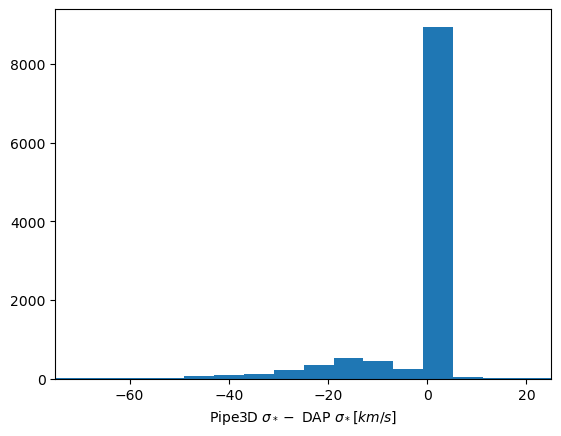

In [65]:
plt.hist(Pipe3D_sigma_table['Pipe3D_star_sigma'] - Pipe3D_sigma_table['star_sigma'],bins=100)
plt.xlim(-75,25)
plt.xlabel(r'Pipe3D $\sigma_* -$ DAP $\sigma_* [km/s]$')
plt.savefig(plot_dir + 'Pipe3D_DAP_sigma.png')
plt.show()

### void vs. wall Mr

In [67]:
r_mag = np.hstack([e_mag, s_mag])

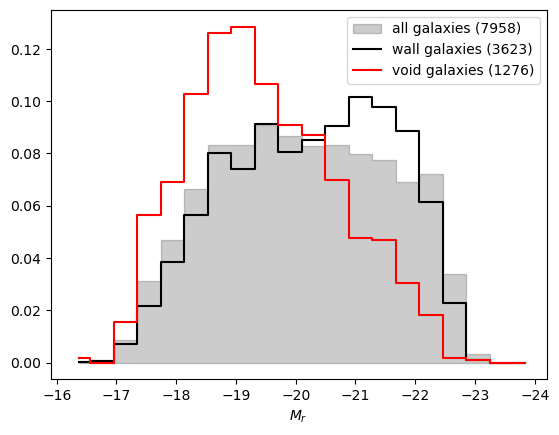

In [74]:
all_mr, bins = np.histogram(r_mag, bins=20)
pts = (bins[1:] + bins[:-1])/2
wall_mr, _ = np.histogram(np.hstack([e_mag[ellipticals['vflag_VF'] == 0], s_mag[spirals['vflag_VF'] == 0]]), bins=bins)
void_mr, _ = np.histogram(np.hstack([e_mag[ellipticals['vflag_VF'] == 1], s_mag[spirals['vflag_VF'] == 1]]), bins=bins)

plt.fill_between(pts, all_mr/np.sum(all_mr), 0, step = 'mid', color='k', alpha=0.2, label='all galaxies ({})'.format(np.sum(all_mr)))
plt.step(pts, wall_mr/np.sum(wall_mr), color='k', where='mid', label='wall galaxies ({})'.format(np.sum(wall_mr)))
plt.step(pts, void_mr/np.sum(void_mr), color='r', where='mid', label='void galaxies ({})'.format(np.sum(void_mr)))

plt.legend()
#plt.xlim(np.max(bins) + 0.2, np.min(bins) - 0.2)
#plt.ylim(0, 760)
plt.xlim(-15.9, -24.2)
plt.xlabel(r'$M_r$')
plt.savefig(plot_dir+'void_wall_mr_hist.png')
plt.show()

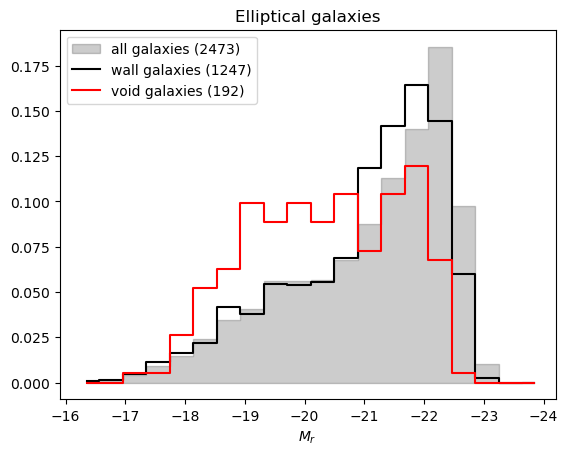

In [75]:
all_mr, bins = np.histogram(e_mag, bins=20)
pts = (bins[1:] + bins[:-1])/2
wall_mr, _ = np.histogram(e_mag[ellipticals['vflag_VF'] == 0], bins=bins)
void_mr, _ = np.histogram(e_mag[ellipticals['vflag_VF'] == 1], bins=bins)

plt.fill_between(pts, all_mr/np.sum(all_mr), 0, step = 'mid', color='k', alpha=0.2, label='all galaxies ({})'.format(np.sum(all_mr)))
plt.step(pts, wall_mr/np.sum(wall_mr), color='k', where='mid', label='wall galaxies ({})'.format(np.sum(wall_mr)))
plt.step(pts, void_mr/np.sum(void_mr), color='r', where='mid', label='void galaxies ({})'.format(np.sum(void_mr)))

plt.legend()
plt.title('Elliptical galaxies')
plt.xlim(-15.9, -24.2)
#plt.ylim(0, 760)
plt.xlabel(r'$M_r$')
plt.savefig(plot_dir+'void_wall_mr_hist_elliptical.png')
plt.show()

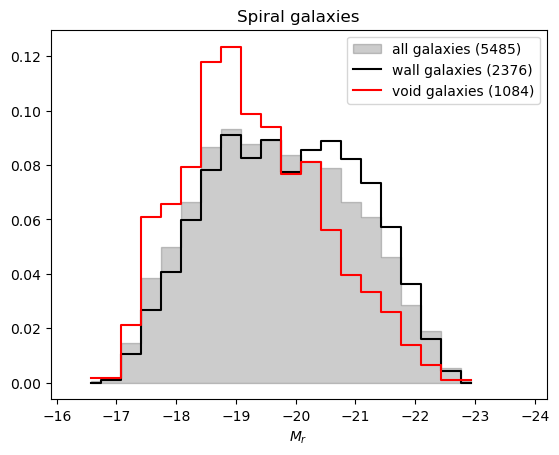

In [76]:
all_mr, bins = np.histogram(s_mag, bins=20)
pts = (bins[1:] + bins[:-1])/2
wall_mr, _ = np.histogram(s_mag[spirals['vflag_VF'] == 0], bins=bins)
void_mr, _ = np.histogram(s_mag[spirals['vflag_VF'] == 1], bins=bins)

plt.fill_between(pts, all_mr/np.sum(all_mr), 0, step = 'mid', color='k', alpha=0.2, label='all galaxies ({})'.format(np.sum(all_mr)))
plt.step(pts, wall_mr/np.sum(wall_mr), color='k', where='mid', label='wall galaxies ({})'.format(np.sum(wall_mr)))
plt.step(pts, void_mr/np.sum(void_mr), color='r', where='mid', label='void galaxies ({})'.format(np.sum(void_mr)))

plt.legend()
plt.xlim(-15.9, -24.2)
plt.xlabel(r'$M_r$')
plt.title('Spiral galaxies')
plt.savefig(plot_dir+'void_wall_mr_hist_spiral.png')
plt.show()

### void vs. wall total mass

In [78]:
tot_mass = np.hstack([spirals['M_R90'].data, ellipticals['Mvir'].data])

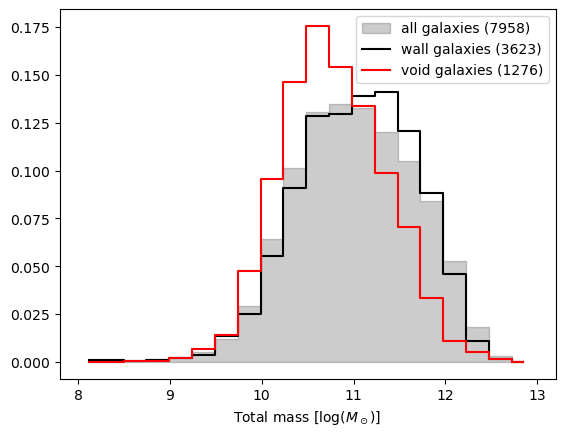

In [86]:
all_mass, bins = np.histogram(tot_mass, bins=20)
pts = (bins[1:] + bins[:-1])/2
wall_mass, _ = np.histogram(np.hstack([ellipticals[ellipticals['vflag_VF'] == 0]['Mvir'].data, 
                   spirals[spirals['vflag_VF'] == 0]['M_R90'].data]), bins=bins)
void_mass, _ = np.histogram(np.hstack([ellipticals[ellipticals['vflag_VF'] == 1]['Mvir'].data, 
                   spirals[spirals['vflag_VF'] == 1]['M_R90'].data]), bins=bins)

plt.fill_between(pts, all_mass/np.sum(all_mass), 0, step = 'mid', color='k', alpha=0.2, label='all galaxies ({})'.format(np.sum(all_mass)))
plt.step(pts, wall_mass/np.sum(wall_mass), color='k', where='mid', label='wall galaxies ({})'.format(np.sum(wall_mass)))
plt.step(pts, void_mass/np.sum(void_mass), color='r', where='mid', label='void galaxies ({})'.format(np.sum(void_mass)))

plt.legend()
plt.xlim(7.8, 13.2)
#plt.ylim(0,1199)
plt.xlabel(r'Total mass [$\log(M_\odot)$]')
plt.savefig(plot_dir+'void_wall_Mtot_hist.png')
plt.show()

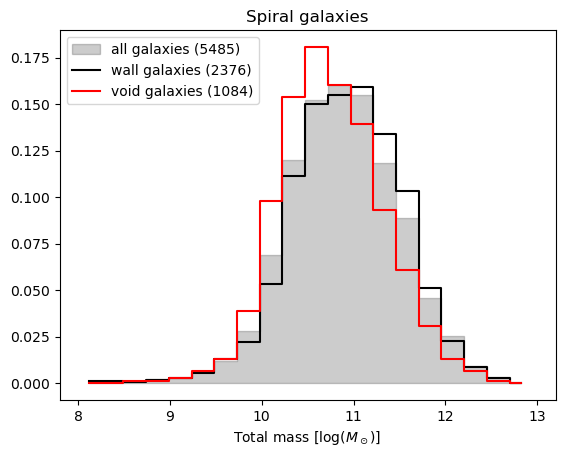

In [85]:
all_mass, bins = np.histogram(spirals['M_R90'], bins=20)
pts = (bins[1:] + bins[:-1])/2
wall_mass, _ = np.histogram(spirals[spirals['vflag_VF'] == 0]['M_R90'].data, bins=bins)
void_mass, _ = np.histogram(spirals[spirals['vflag_VF'] == 1]['M_R90'].data, bins=bins)

plt.fill_between(pts, all_mass/np.sum(all_mass), 0, step = 'mid', color='k', alpha=0.2, label='all galaxies ({})'.format(np.sum(all_mass)))
plt.step(pts, wall_mass/np.sum(wall_mass), color='k', where='mid', label='wall galaxies ({})'.format(np.sum(wall_mass)))
plt.step(pts, void_mass/np.sum(void_mass), color='r', where='mid', label='void galaxies ({})'.format(np.sum(void_mass)))

plt.xlim(7.8, 13.2)
plt.legend()
plt.title('Spiral galaxies')
plt.xlabel(r'Total mass [$\log(M_\odot)$]')
plt.savefig(plot_dir+'void_wall_Mtot_hist_spirals.png')
plt.show()

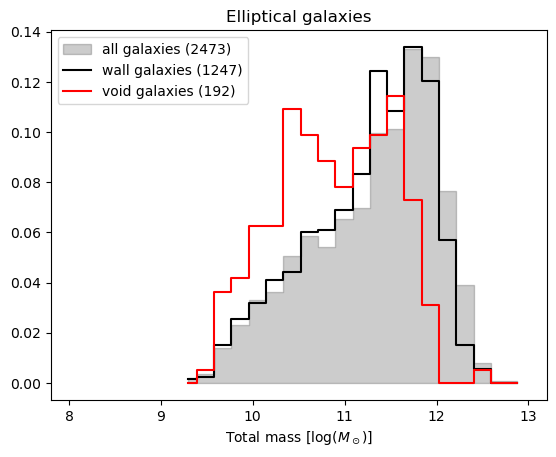

In [87]:
all_mass, bins = np.histogram(ellipticals['Mvir'], bins=20)
pts = (bins[1:] + bins[:-1])/2
wall_mass, _ = np.histogram(ellipticals[ellipticals['vflag_VF'] == 0]['Mvir'].data, bins=bins)
void_mass, _ = np.histogram(ellipticals[ellipticals['vflag_VF'] == 1]['Mvir'].data, bins=bins)

plt.fill_between(pts, all_mass/np.sum(all_mass), 0, step = 'mid', color='k', alpha=0.2, label='all galaxies ({})'.format(np.sum(all_mass)))
plt.step(pts, wall_mass/np.sum(wall_mass), color='k', where='mid', label='wall galaxies ({})'.format(np.sum(wall_mass)))
plt.step(pts, void_mass/np.sum(void_mass), color='r', where='mid', label='void galaxies ({})'.format(np.sum(void_mass)))

plt.legend()

plt.xlim(7.8, 13.2)
plt.title('Elliptical galaxies')
plt.xlabel(r'Total mass [$\log(M_\odot)$]')
plt.savefig(plot_dir+'void_wall_Mtot_hist_ellipticals.png')
plt.show()

### void vs. wall sSFR (dr7)

In [88]:
sSFR = np.hstack([(spirals['SFR'].data - spirals['M90_disk'].data), (ellipticals['SFR'] - np.log10(ellipticals['nsa_elpetro_mass'].data))])

In [106]:
sSFR = sSFR[np.isnan(sSFR) == False]

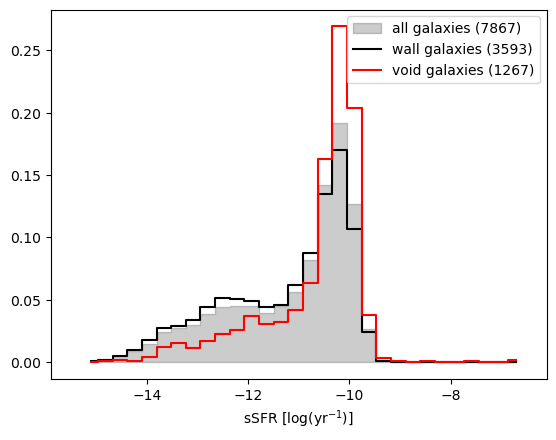

In [110]:
all_sSFR, bins = np.histogram(sSFR, bins=30)
pts = (bins[1:] + bins[:-1])/2
wall_sSFR, _ = np.histogram(np.hstack([ellipticals[ellipticals['vflag_VF'] == 0]['SFR'].data - np.log10(ellipticals[ellipticals['vflag_VF'] == 0]['nsa_elpetro_mass'].data), 
                   spirals[spirals['vflag_VF'] == 0]['SFR'].data - spirals[spirals['vflag_VF'] == 0]['M90_disk'].data]), 
                            bins=bins)
void_sSFR, _ = np.histogram(np.hstack([ellipticals[ellipticals['vflag_VF'] == 1]['SFR'].data - np.log10(ellipticals[ellipticals['vflag_VF'] == 1]['nsa_elpetro_mass'].data), 
                   spirals[spirals['vflag_VF'] == 1]['SFR'].data - spirals[spirals['vflag_VF'] == 1]['M90_disk'].data]), 
                            bins=bins)

plt.fill_between(pts, all_sSFR/np.sum(all_sSFR), 0, step = 'mid', color='k', alpha=0.2, label='all galaxies ({})'.format(np.sum(all_sSFR)))
plt.step(pts, wall_sSFR/np.sum(wall_sSFR), color='k', where='mid', label='wall galaxies ({})'.format(np.sum(wall_sSFR)))
plt.step(pts, void_sSFR/np.sum(void_sSFR), color='r', where='mid', label='void galaxies ({})'.format(np.sum(void_sSFR)))

plt.xlim(-15.9, -6.1)
plt.legend()
plt.xlabel(r'sSFR [$\log($yr$^{-1})$]')
plt.savefig(plot_dir+'void_wall_sSFR_hist.png')
plt.show()

In [112]:
s_sSFR = spirals['SFR'].data - spirals['M90_disk'].data
s_sSFR = s_sSFR[np.isnan(s_sSFR) == False]

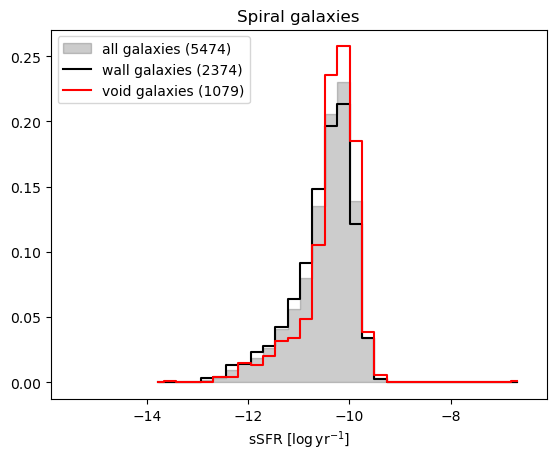

In [113]:
all_sSFR, bins = np.histogram(s_sSFR, bins=30)
pts = (bins[1:] + bins[:-1])/2
wall_sSFR, _ = np.histogram(spirals[spirals['vflag_VF'] == 0]['SFR'].data - spirals[spirals['vflag_VF'] == 0]['M90_disk'].data, 
                            bins=bins)
void_sSFR, _ = np.histogram(spirals[spirals['vflag_VF'] == 1]['SFR'].data - spirals[spirals['vflag_VF'] == 1]['M90_disk'].data, 
                            bins=bins)

plt.fill_between(pts, all_sSFR/np.sum(all_sSFR), 0, step = 'mid', color='k', alpha=0.2, label='all galaxies ({})'.format(np.sum(all_sSFR)))
plt.step(pts, wall_sSFR/np.sum(wall_sSFR), color='k', where='mid', label='wall galaxies ({})'.format(np.sum(wall_sSFR)))
plt.step(pts, void_sSFR/np.sum(void_sSFR), color='r', where='mid', label='void galaxies ({})'.format(np.sum(void_sSFR)))

plt.xlim(-15.9, -6.1)

plt.legend()
plt.title('Spiral galaxies')
plt.xlabel(r'sSFR [$\log$yr$^{-1}$]')
plt.savefig(plot_dir+'void_wall_sSFR_hist_spiral.png')
plt.show()

In [115]:
e_sSFR = ellipticals['SFR'] - np.log10(ellipticals['nsa_elpetro_mass'].data)
e_sSFR = e_sSFR[np.isnan(e_sSFR) == False]
                                       

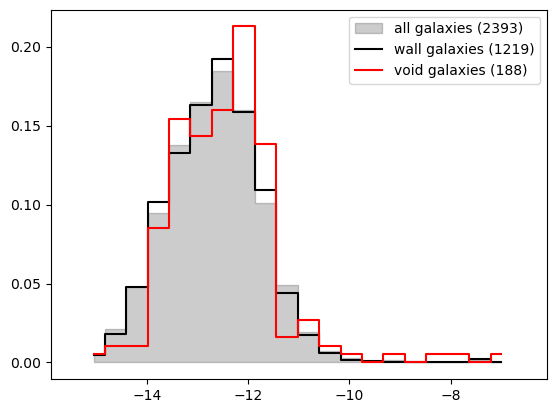

In [117]:
all_sSFR, bins = np.histogram(e_sSFR, bins=20)
pts = (bins[1:] + bins[:-1])/2
wall_sSFR, _ = np.histogram(ellipticals[ellipticals['vflag_VF'] == 0]['SFR'].data - np.log10(ellipticals[ellipticals['vflag_VF'] == 0]['nsa_elpetro_mass'].data), 
                            bins=bins)
void_sSFR, _ = np.histogram(ellipticals[ellipticals['vflag_VF'] == 1]['SFR'].data - np.log10(ellipticals[ellipticals['vflag_VF'] == 1]['nsa_elpetro_mass'].data),
                            bins=bins)

plt.fill_between(pts, all_sSFR/np.sum(all_sSFR), 0, step = 'mid', color='k', alpha=0.2, label='all galaxies ({})'.format(np.sum(all_sSFR)))
plt.step(pts, wall_sSFR/np.sum(wall_sSFR), color='k', where='mid', label='wall galaxies ({})'.format(np.sum(wall_sSFR)))
plt.step(pts, void_sSFR/np.sum(void_sSFR), color='r', where='mid', label='void galaxies ({})'.format(np.sum(void_sSFR)))

plt.xlim(-15.9, -6.1)
plt.legend()
plt.savefig(plot_dir+'void_wall_sSFR_hist_ellipticals.png')
plt.show()